In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   salerno
   2   prato
   3   potenza
   4   matera
   5   reggio_nell_emilia
   6   rieti
   7   lecco
   8   siena
   9   lecce
   10   venezia
   11   bologna
   12   viterbo
   13   frosinone
   14   carbonia
   15   agrigento
   16   catanzaro
   17   imperia
   18   crotone
   19   bari
   20   foggia
   21   monza
   22   caserta
   23   trento
   24   alessandria
   25   latina
   26   isernia
   27   bergamo
   28   savona
   29   biella
   30   vercelli
   31   piacenza
   32   campobasso
   33   treviso
   34   terni
   35   cuneo
   36   gorizia
   37   como
   38   lucca
   39   firenze
   40   enna
   41   parma
   42   pisa
   43   grosseto
   44   benevento
   45   verona
   46   bat
   47   teramo
   48   messina
   49   massa
   50   cagliari
   51   ancona
   52   mantova
   53   udine
   54   genova
   55   pordenone
   56   rovigo
   57   fermo
   58   varese
   59   napoli
   60   perug

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 salerno
2 prato
3 potenza
4 matera
5 reggio_nell_emilia
6 rieti
7 lecco
8 siena
9 lecce
10 venezia
11 bologna
12 viterbo
13 frosinone
14 agrigento
15 catanzaro
16 imperia
17 crotone
18 bari
19 foggia
20 monza
21 caserta
22 trento
23 alessandria
24 latina
25 bergamo
26 savona
27 biella
28 vercelli
29 piacenza
30 campobasso
31 treviso
32 terni
33 cuneo
34 gorizia
35 como
36 lucca
37 firenze
38 enna
39 parma
40 pisa
41 grosseto
42 benevento
43 verona
44 bat
45 teramo
46 messina
47 massa
48 cagliari
49 ancona
50 mantova
51 udine
52 genova
53 pordenone
54 rovigo
55 fermo
56 varese
57 napoli
58 perugia
59 catania
60 rimini
61 pesaro
62 arezzo
63 forli
64 verbania
65 vicenza
66 pavia
67 belluno
68 trapani
69 brescia
70 oristano
71 roma
72 ragusa
73 macerata
74 bolzano
75 l_aquila
76 reggio_di_calabria
77 chieti
78 brindisi
79 vibo_valentia
80 novara
81 modena
82 caltanissetta
83 cremona
84 pescara
85 milano
86 lodi
87 asti
88 trieste
89 sassari
90 ferrara
91 sondrio
92 siracusa
93 la_spezia

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

A seguire i test cercando di minimizzare l'overfitting 

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34543  0.02361 
    Test set average RMSE:  0.95276  0.10287 

Prediction STD :  1.2834918889332783
True value STD:   1.4782591096169262
Difference in percentage:  13.17544532055139

             Fullset RMSE:  0.34438
                       R2:  0.94573


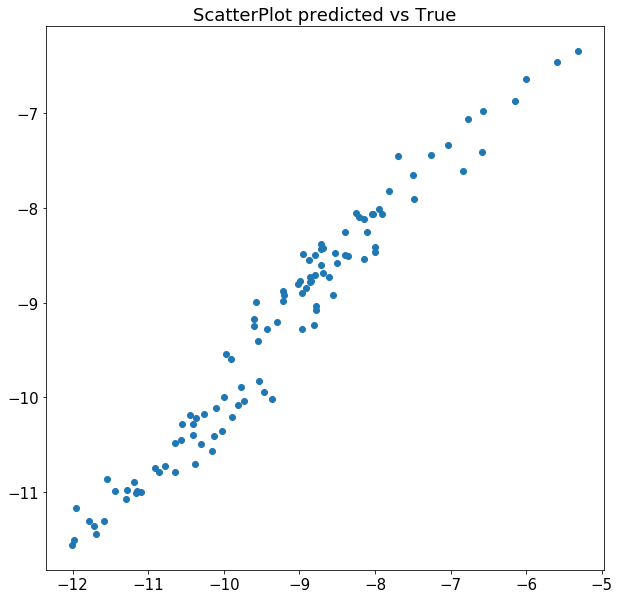

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04233 +/- 0.00511
Feature:               commutersdensity, Score: 0.02467 +/- 0.00290
Feature:                         depriv, Score: 0.05204 +/- 0.00508
Feature:                            lat, Score: 2.87181 +/- 0.38879
Feature:                 Ratio0200ver65, Score: 0.12025 +/- 0.02041
Feature:         avg_wpm10_period1_2020, Score: 0.19630 +/- 0.02411
Feature:           avg_wno_period1_2020, Score: 0.18481 +/- 0.02594
Feature:         avg_wpans_period1_2020, Score: 0.05215 +/- 0.00729
Feature:          avg_wso2_period1_2020, Score: 0.06975 +/- 0.00954
Feature:                  randomfeature, Score: 0.05803 +/- 0.00957


<Figure size 432x288 with 0 Axes>

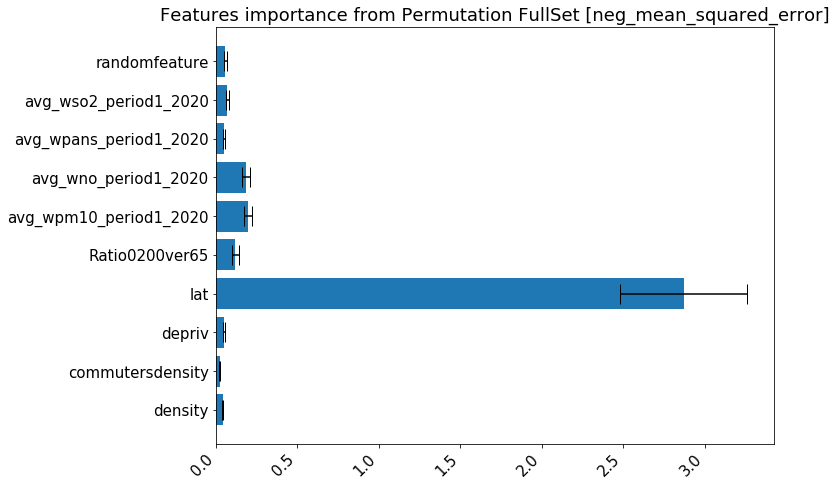

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.01937 +/- 0.00234
Feature:               commutersdensity, Score: 0.01129 +/- 0.00133
Feature:                         depriv, Score: 0.02381 +/- 0.00232
Feature:                            lat, Score: 1.31418 +/- 0.17792
Feature:                 Ratio0200ver65, Score: 0.05503 +/- 0.00934
Feature:         avg_wpm10_period1_2020, Score: 0.08983 +/- 0.01103
Feature:           avg_wno_period1_2020, Score: 0.08457 +/- 0.01187
Feature:         avg_wpans_period1_2020, Score: 0.02387 +/- 0.00333
Feature:          avg_wso2_period1_2020, Score: 0.03192 +/- 0.00437
Feature:                  randomfeature, Score: 0.02656 +/- 0.00438


<Figure size 432x288 with 0 Axes>

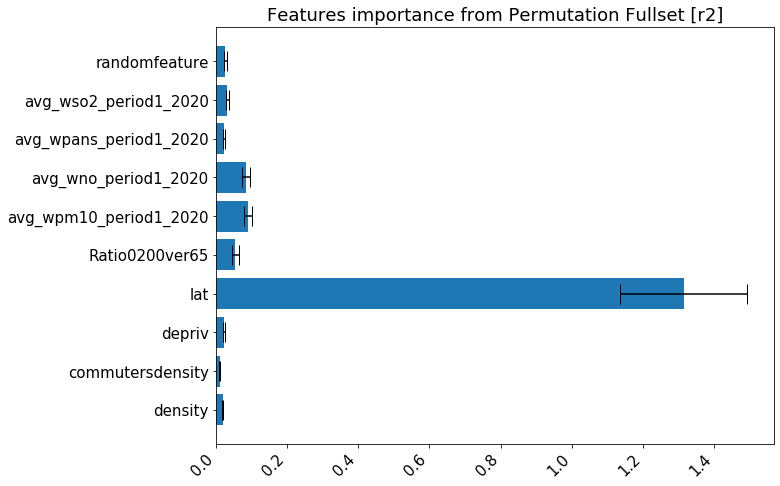

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.02204 +/- 0.02435
Feature:               commutersdensity, Score: 0.01329 +/- 0.01822
Feature:                         depriv, Score: 0.01748 +/- 0.02403
Feature:                            lat, Score: 2.06554 +/- 0.65562
Feature:                 Ratio0200ver65, Score: 0.03133 +/- 0.06858
Feature:         avg_wpm10_period1_2020, Score: -0.04677 +/- 0.05006
Feature:           avg_wno_period1_2020, Score: 0.01194 +/- 0.03331
Feature:         avg_wpans_period1_2020, Score: -0.00078 +/- 0.01464
Feature:          avg_wso2_period1_2020, Score: 0.01778 +/- 0.03937
Feature:                  randomfeature, Score: -0.00262 +/- 0.03132


<Figure size 432x288 with 0 Axes>

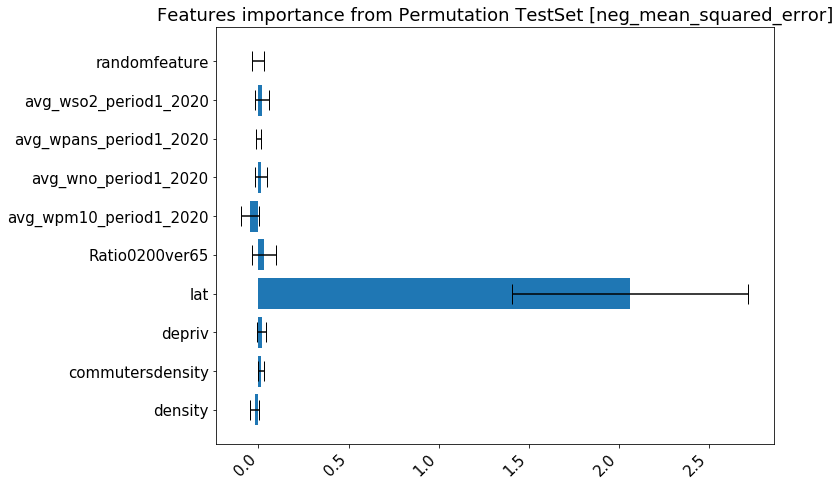

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01506 +/- 0.01664
Feature:               commutersdensity, Score: 0.00908 +/- 0.01245
Feature:                         depriv, Score: 0.01194 +/- 0.01642
Feature:                            lat, Score: 1.41164 +/- 0.44806
Feature:                 Ratio0200ver65, Score: 0.02141 +/- 0.04687
Feature:         avg_wpm10_period1_2020, Score: -0.03196 +/- 0.03422
Feature:           avg_wno_period1_2020, Score: 0.00816 +/- 0.02276
Feature:         avg_wpans_period1_2020, Score: -0.00053 +/- 0.01000
Feature:          avg_wso2_period1_2020, Score: 0.01215 +/- 0.02691
Feature:                  randomfeature, Score: -0.00179 +/- 0.02141


<Figure size 432x288 with 0 Axes>

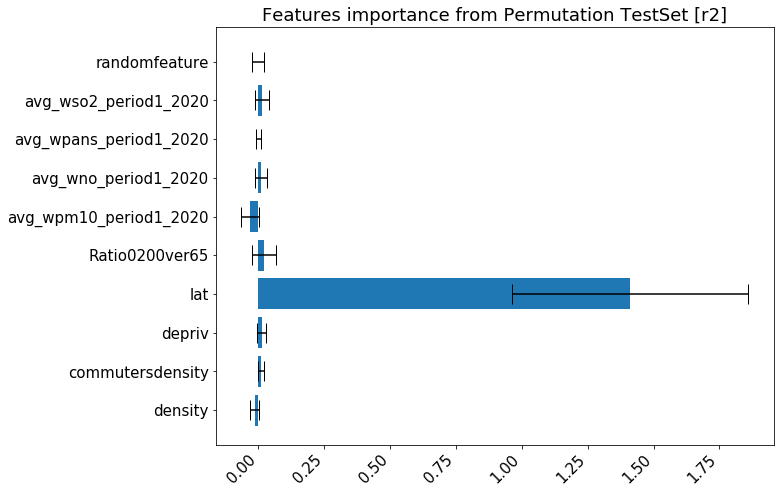

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04459 +/- 0.00866
Feature:               commutersdensity, Score: 0.02861 +/- 0.00467
Feature:                         depriv, Score: 0.04529 +/- 0.00586
Feature:                            lat, Score: 3.04623 +/- 0.42285
Feature:                 Ratio0200ver65, Score: 0.15390 +/- 0.02933
Feature:         avg_wpm10_period1_2020, Score: 0.26413 +/- 0.03521
Feature:           avg_wno_period1_2020, Score: 0.09809 +/- 0.01359
Feature:         avg_wpans_period1_2020, Score: 0.04500 +/- 0.00510
Feature:          avg_wso2_period1_2020, Score: 0.09824 +/- 0.01824
Feature:                  randomfeature, Score: 0.06387 +/- 0.00979


<Figure size 432x288 with 0 Axes>

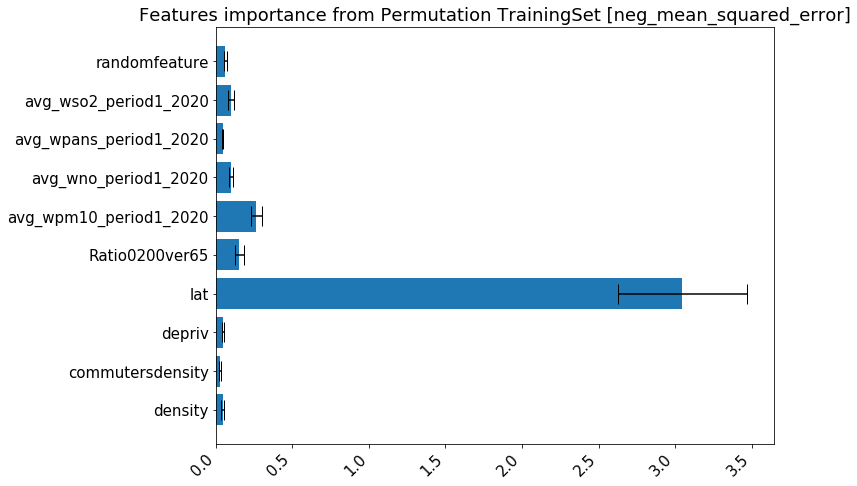

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.01889 +/- 0.00367
Feature:               commutersdensity, Score: 0.01212 +/- 0.00198
Feature:                         depriv, Score: 0.01919 +/- 0.00248
Feature:                            lat, Score: 1.29074 +/- 0.17917
Feature:                 Ratio0200ver65, Score: 0.06521 +/- 0.01243
Feature:         avg_wpm10_period1_2020, Score: 0.11192 +/- 0.01492
Feature:           avg_wno_period1_2020, Score: 0.04156 +/- 0.00576
Feature:         avg_wpans_period1_2020, Score: 0.01907 +/- 0.00216
Feature:          avg_wso2_period1_2020, Score: 0.04162 +/- 0.00773
Feature:                  randomfeature, Score: 0.02706 +/- 0.00415


<Figure size 432x288 with 0 Axes>

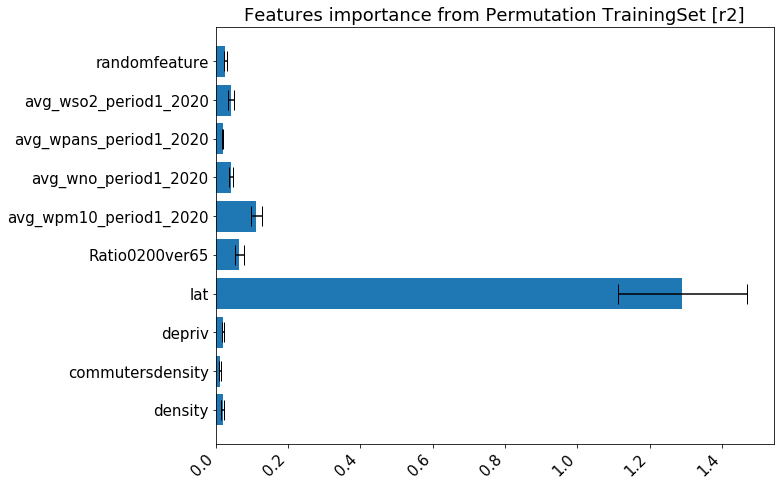

<Figure size 720x720 with 0 Axes>

In [6]:

importlib.reload(smlmodule)
import pprint

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
        smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
        plotname="rf_model_allfeatures_optoverfit", showplot=True, optimisedparams=besthyperF)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38258  0.02481 
    Test set average RMSE:  1.02728  0.10238 

Prediction STD :  1.2576184344686978
True value STD:   1.4782591096169262
Difference in percentage:  14.92571050046868

             Fullset RMSE:  0.36651
                       R2:  0.93853


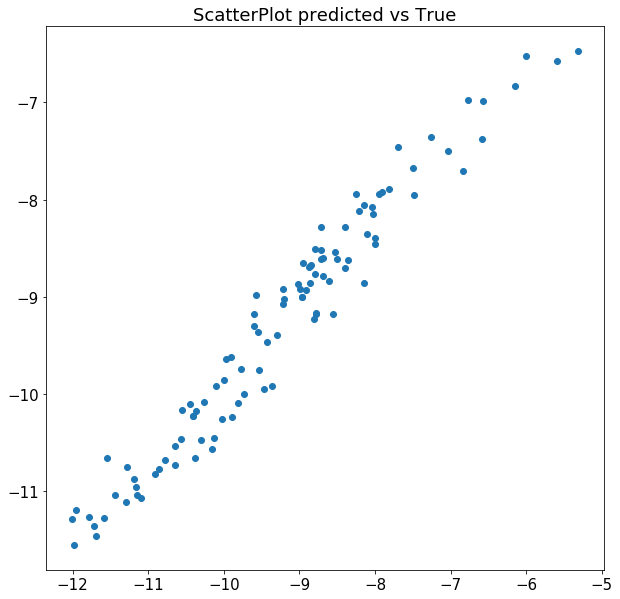

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05178 +/- 0.00569
Feature:               commutersdensity, Score: 1.54010 +/- 0.24168
Feature:                         depriv, Score: 0.07624 +/- 0.01118
Feature:                 Ratio0200ver65, Score: 0.18815 +/- 0.02636
Feature:         avg_wpm10_period1_2020, Score: 0.26196 +/- 0.03224
Feature:           avg_wno_period1_2020, Score: 0.38021 +/- 0.04752
Feature:         avg_wpans_period1_2020, Score: 0.09081 +/- 0.01331
Feature:          avg_wso2_period1_2020, Score: 0.10397 +/- 0.01314
Feature:                  randomfeature, Score: 0.06238 +/- 0.01098


<Figure size 432x288 with 0 Axes>

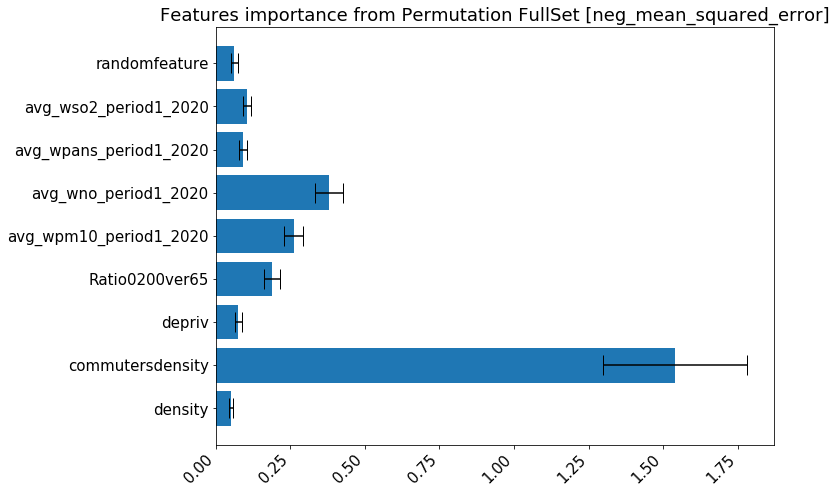

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02369 +/- 0.00260
Feature:               commutersdensity, Score: 0.70477 +/- 0.11060
Feature:                         depriv, Score: 0.03489 +/- 0.00512
Feature:                 Ratio0200ver65, Score: 0.08610 +/- 0.01206
Feature:         avg_wpm10_period1_2020, Score: 0.11988 +/- 0.01475
Feature:           avg_wno_period1_2020, Score: 0.17399 +/- 0.02175
Feature:         avg_wpans_period1_2020, Score: 0.04156 +/- 0.00609
Feature:          avg_wso2_period1_2020, Score: 0.04758 +/- 0.00601
Feature:                  randomfeature, Score: 0.02855 +/- 0.00503


<Figure size 432x288 with 0 Axes>

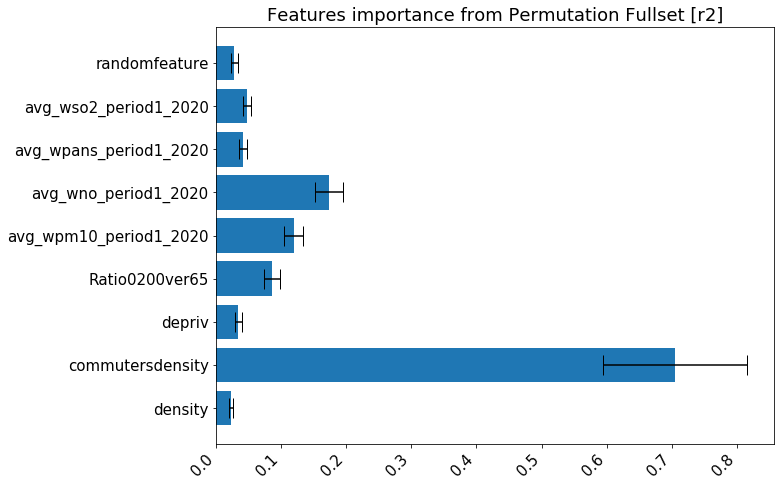

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01835 +/- 0.01922
Feature:               commutersdensity, Score: 1.15131 +/- 0.46898
Feature:                         depriv, Score: -0.04087 +/- 0.04918
Feature:                 Ratio0200ver65, Score: 0.05643 +/- 0.07298
Feature:         avg_wpm10_period1_2020, Score: -0.05019 +/- 0.06013
Feature:           avg_wno_period1_2020, Score: 0.03700 +/- 0.07991
Feature:         avg_wpans_period1_2020, Score: 0.01513 +/- 0.03859
Feature:          avg_wso2_period1_2020, Score: -0.00557 +/- 0.05745
Feature:                  randomfeature, Score: -0.00518 +/- 0.01511


<Figure size 432x288 with 0 Axes>

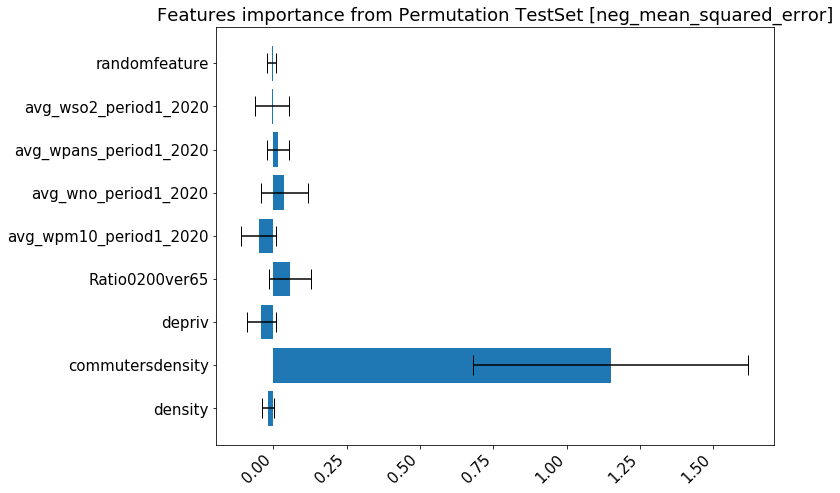

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01254 +/- 0.01314
Feature:               commutersdensity, Score: 0.78683 +/- 0.32051
Feature:                         depriv, Score: -0.02793 +/- 0.03361
Feature:                 Ratio0200ver65, Score: 0.03857 +/- 0.04987
Feature:         avg_wpm10_period1_2020, Score: -0.03430 +/- 0.04109
Feature:           avg_wno_period1_2020, Score: 0.02529 +/- 0.05461
Feature:         avg_wpans_period1_2020, Score: 0.01034 +/- 0.02638
Feature:          avg_wso2_period1_2020, Score: -0.00381 +/- 0.03926
Feature:                  randomfeature, Score: -0.00354 +/- 0.01033


<Figure size 432x288 with 0 Axes>

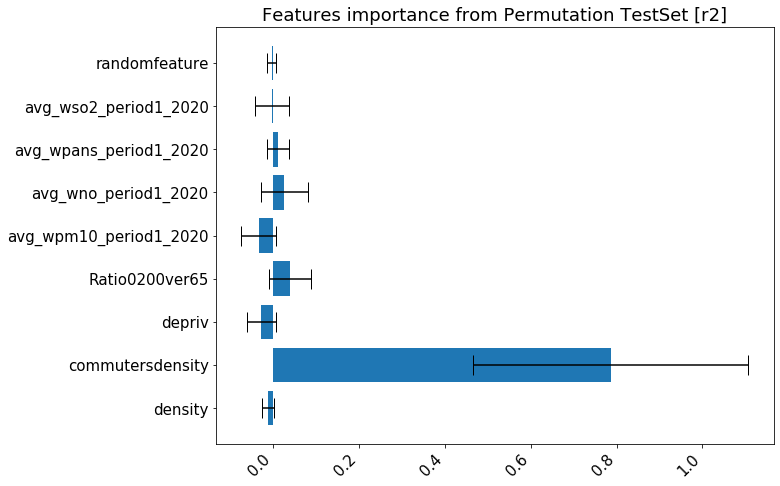

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04654 +/- 0.00572
Feature:               commutersdensity, Score: 1.86519 +/- 0.31404
Feature:                         depriv, Score: 0.08018 +/- 0.01361
Feature:                 Ratio0200ver65, Score: 0.21260 +/- 0.02880
Feature:         avg_wpm10_period1_2020, Score: 0.32218 +/- 0.04911
Feature:           avg_wno_period1_2020, Score: 0.28528 +/- 0.03897
Feature:         avg_wpans_period1_2020, Score: 0.09306 +/- 0.01442
Feature:          avg_wso2_period1_2020, Score: 0.13985 +/- 0.02317
Feature:                  randomfeature, Score: 0.04816 +/- 0.00760


<Figure size 432x288 with 0 Axes>

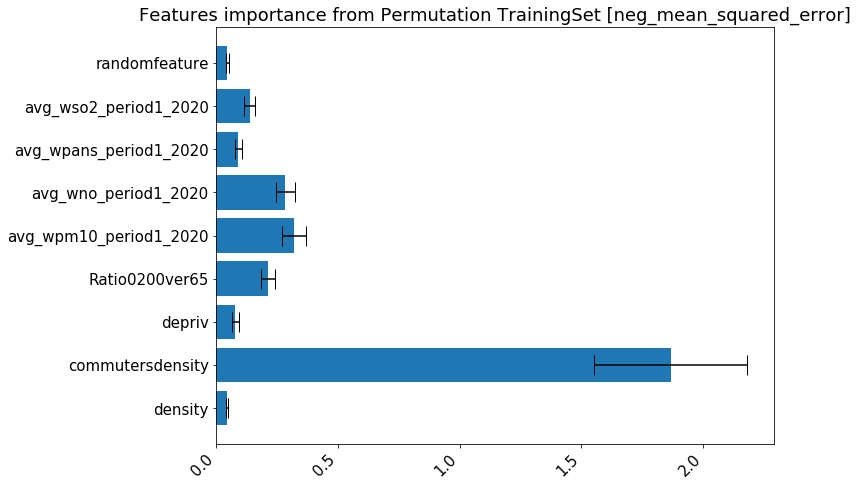

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.01972 +/- 0.00242
Feature:               commutersdensity, Score: 0.79032 +/- 0.13307
Feature:                         depriv, Score: 0.03397 +/- 0.00577
Feature:                 Ratio0200ver65, Score: 0.09008 +/- 0.01220
Feature:         avg_wpm10_period1_2020, Score: 0.13651 +/- 0.02081
Feature:           avg_wno_period1_2020, Score: 0.12088 +/- 0.01651
Feature:         avg_wpans_period1_2020, Score: 0.03943 +/- 0.00611
Feature:          avg_wso2_period1_2020, Score: 0.05926 +/- 0.00982
Feature:                  randomfeature, Score: 0.02040 +/- 0.00322


<Figure size 432x288 with 0 Axes>

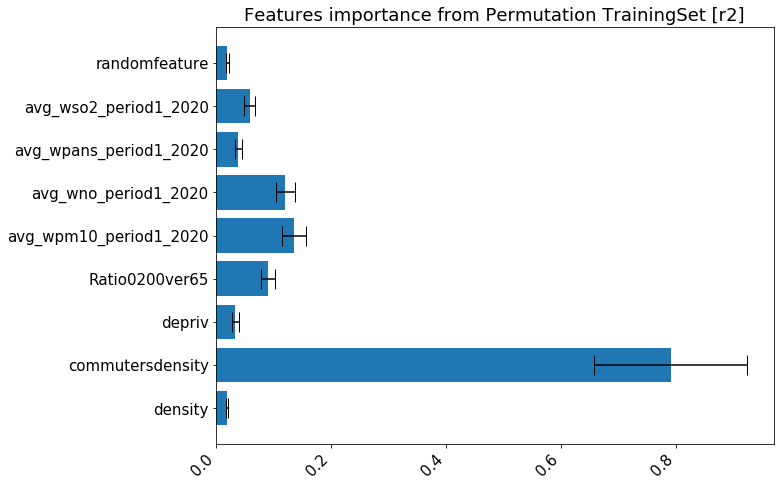

<Figure size 720x720 with 0 Axes>

In [7]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_optoverfit", showplot=True, optimisedparams=besthyperF )

importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=5, pout=sys.stdout, \
    plotname="rf_model_nolat_optoverfit", showplot=True, optimisedparams=besthyperF )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.40386  0.02367 
    Test set average RMSE:  1.10125  0.10740 

Prediction STD :  1.2116584386318336
True value STD:   1.4782591096169262
Difference in percentage:  18.034772743878374

             Fullset RMSE:  0.40048
                       R2:  0.92661


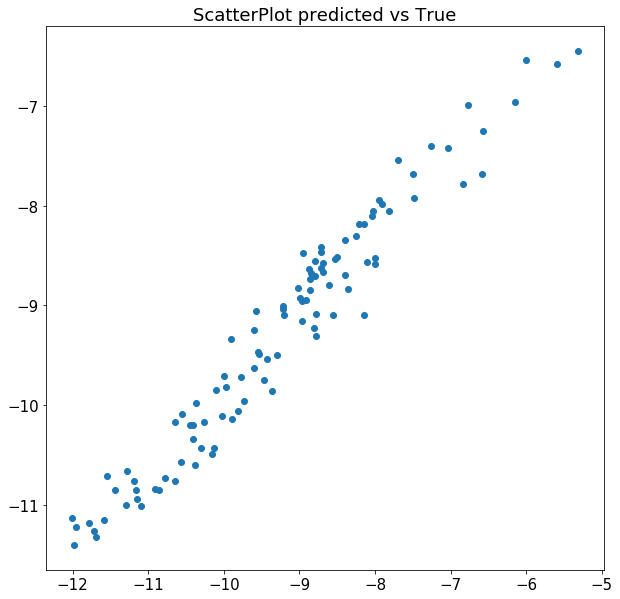

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05278 +/- 0.00648
Feature:                         depriv, Score: 0.56083 +/- 0.08727
Feature:                 Ratio0200ver65, Score: 0.19664 +/- 0.02724
Feature:         avg_wpm10_period1_2020, Score: 0.41327 +/- 0.05193
Feature:           avg_wno_period1_2020, Score: 1.03030 +/- 0.13336
Feature:         avg_wpans_period1_2020, Score: 0.13576 +/- 0.01889
Feature:          avg_wso2_period1_2020, Score: 0.11172 +/- 0.01245
Feature:                  randomfeature, Score: 0.07007 +/- 0.00912


<Figure size 432x288 with 0 Axes>

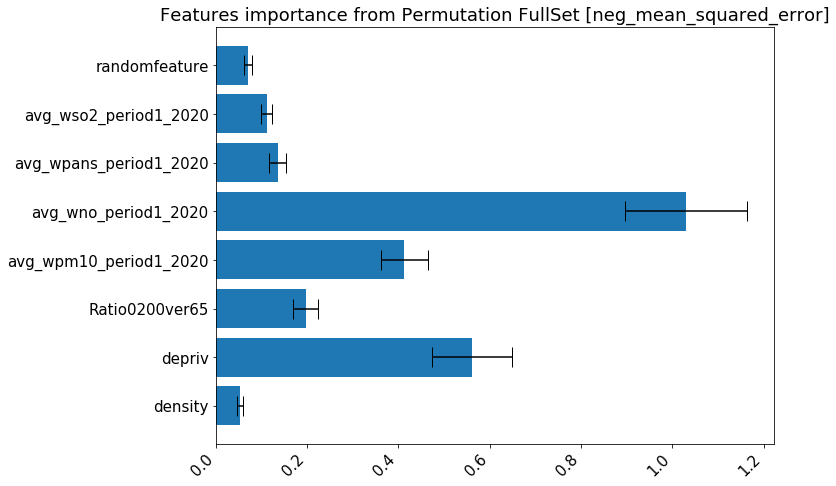

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02415 +/- 0.00296
Feature:                         depriv, Score: 0.25664 +/- 0.03993
Feature:                 Ratio0200ver65, Score: 0.08998 +/- 0.01247
Feature:         avg_wpm10_period1_2020, Score: 0.18912 +/- 0.02376
Feature:           avg_wno_period1_2020, Score: 0.47148 +/- 0.06103
Feature:         avg_wpans_period1_2020, Score: 0.06213 +/- 0.00864
Feature:          avg_wso2_period1_2020, Score: 0.05112 +/- 0.00570
Feature:                  randomfeature, Score: 0.03207 +/- 0.00417


<Figure size 432x288 with 0 Axes>

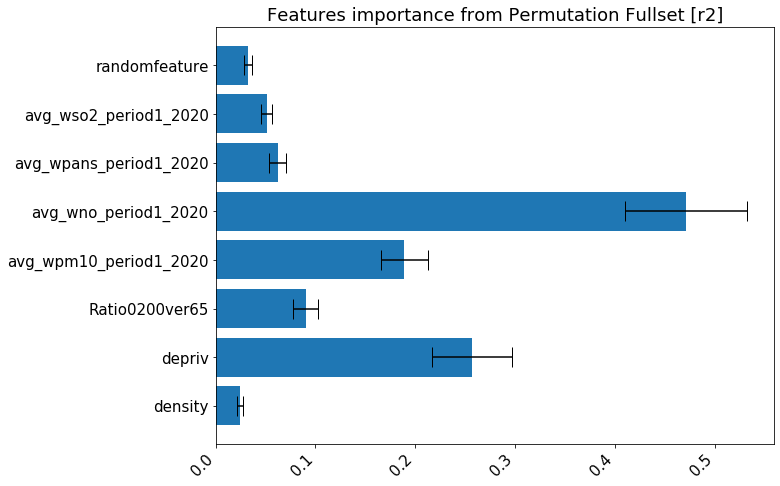

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00656 +/- 0.01397
Feature:                         depriv, Score: 0.40312 +/- 0.15626
Feature:                 Ratio0200ver65, Score: 0.06370 +/- 0.06895
Feature:         avg_wpm10_period1_2020, Score: 0.02083 +/- 0.05960
Feature:           avg_wno_period1_2020, Score: 0.43748 +/- 0.16520
Feature:         avg_wpans_period1_2020, Score: 0.09438 +/- 0.05118
Feature:          avg_wso2_period1_2020, Score: -0.01074 +/- 0.04649
Feature:                  randomfeature, Score: 0.01649 +/- 0.01773


<Figure size 432x288 with 0 Axes>

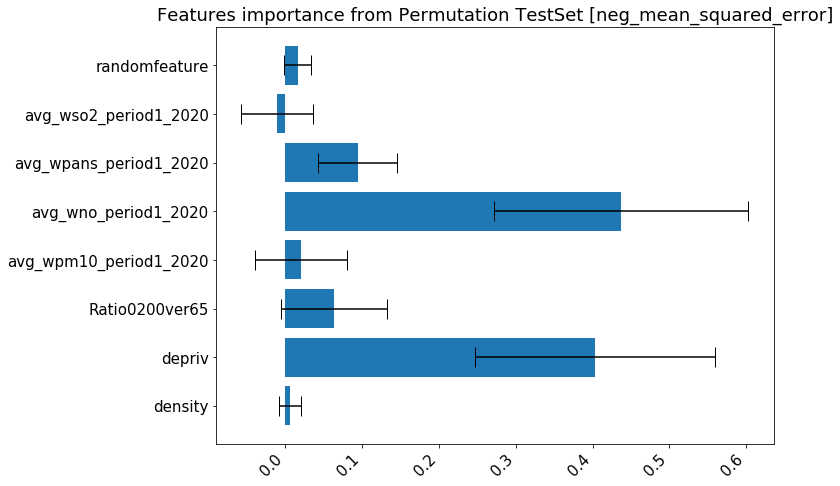

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00448 +/- 0.00955
Feature:                         depriv, Score: 0.27550 +/- 0.10679
Feature:                 Ratio0200ver65, Score: 0.04353 +/- 0.04712
Feature:         avg_wpm10_period1_2020, Score: 0.01424 +/- 0.04073
Feature:           avg_wno_period1_2020, Score: 0.29898 +/- 0.11290
Feature:         avg_wpans_period1_2020, Score: 0.06450 +/- 0.03498
Feature:          avg_wso2_period1_2020, Score: -0.00734 +/- 0.03177
Feature:                  randomfeature, Score: 0.01127 +/- 0.01212


<Figure size 432x288 with 0 Axes>

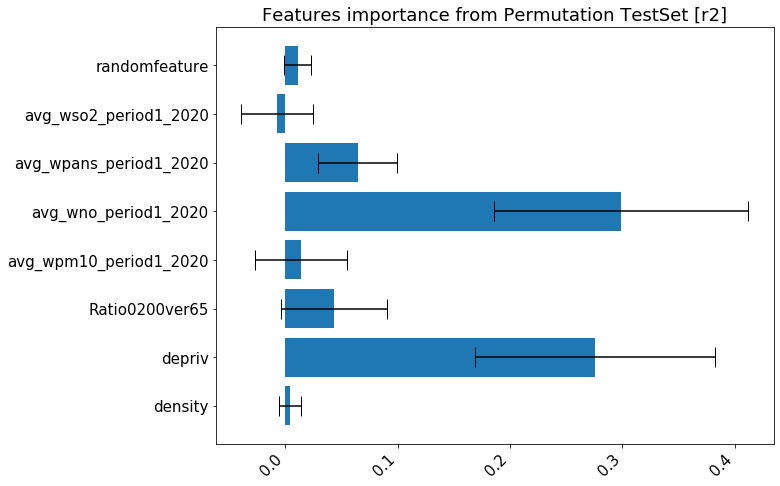

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07281 +/- 0.01062
Feature:                         depriv, Score: 0.68715 +/- 0.12969
Feature:                 Ratio0200ver65, Score: 0.21393 +/- 0.03166
Feature:         avg_wpm10_period1_2020, Score: 0.41779 +/- 0.05806
Feature:           avg_wno_period1_2020, Score: 1.12058 +/- 0.16204
Feature:         avg_wpans_period1_2020, Score: 0.15271 +/- 0.02520
Feature:          avg_wso2_period1_2020, Score: 0.14571 +/- 0.02039
Feature:                  randomfeature, Score: 0.06943 +/- 0.01018


<Figure size 432x288 with 0 Axes>

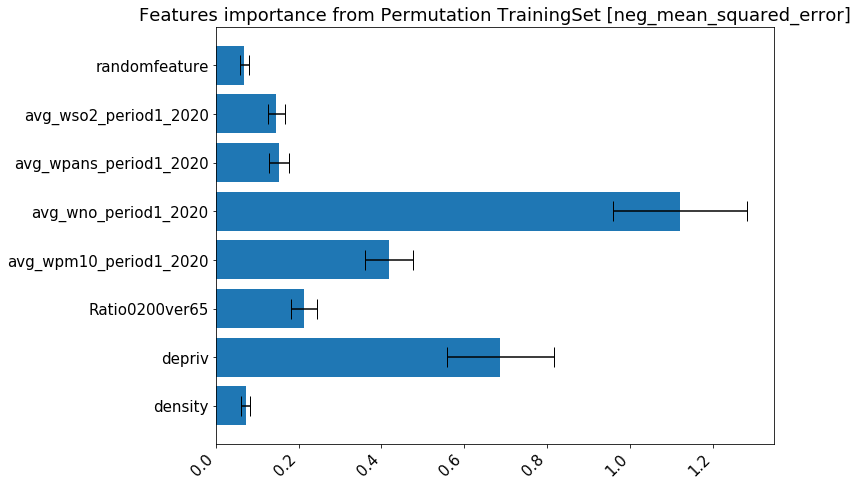

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03085 +/- 0.00450
Feature:                         depriv, Score: 0.29116 +/- 0.05495
Feature:                 Ratio0200ver65, Score: 0.09065 +/- 0.01341
Feature:         avg_wpm10_period1_2020, Score: 0.17702 +/- 0.02460
Feature:           avg_wno_period1_2020, Score: 0.47481 +/- 0.06866
Feature:         avg_wpans_period1_2020, Score: 0.06471 +/- 0.01068
Feature:          avg_wso2_period1_2020, Score: 0.06174 +/- 0.00864
Feature:                  randomfeature, Score: 0.02942 +/- 0.00432


<Figure size 432x288 with 0 Axes>

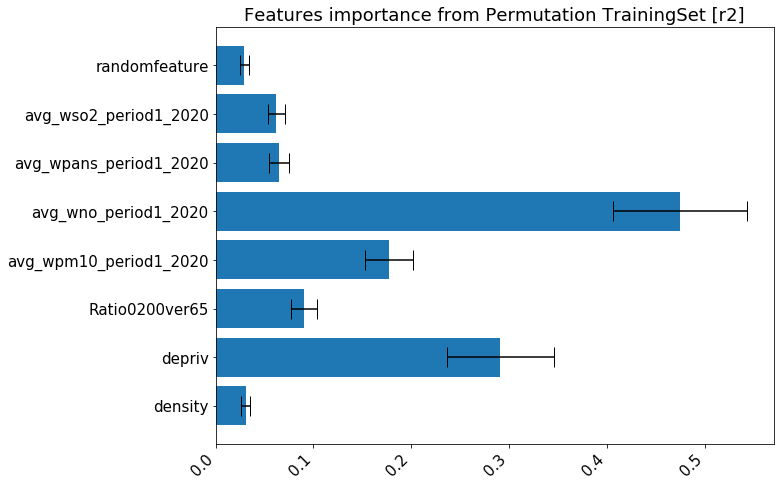

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_optoverfit", showplot=True, optimisedparams=besthyperF)

A seguire cercando di minimizzare invece RMSE su intero set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34159  0.01970 
    Test set average RMSE:  0.97884  0.08418 

Prediction STD :  1.2853595584804747
True value STD:   1.4782591096169262
Difference in percentage:  13.0491028184118

             Fullset RMSE:  0.33963
                       R2:  0.94722


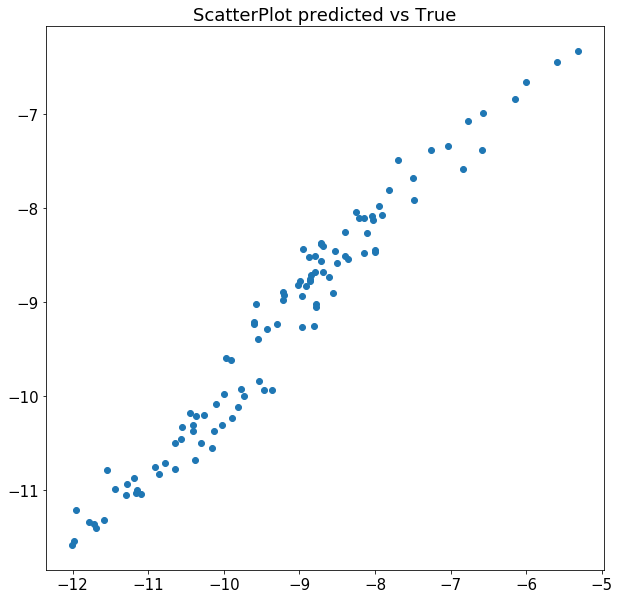

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04309 +/- 0.00407
Feature:               commutersdensity, Score: 0.02638 +/- 0.00264
Feature:                         depriv, Score: 0.05075 +/- 0.00436
Feature:                            lat, Score: 2.73561 +/- 0.37875
Feature:                 Ratio0200ver65, Score: 0.10248 +/- 0.01711
Feature:         avg_wpm10_period1_2020, Score: 0.19367 +/- 0.02318
Feature:           avg_wno_period1_2020, Score: 0.20950 +/- 0.02730
Feature:         avg_wpans_period1_2020, Score: 0.05927 +/- 0.00749
Feature:          avg_wso2_period1_2020, Score: 0.06970 +/- 0.01173
Feature:                  randomfeature, Score: 0.06013 +/- 0.00966


<Figure size 432x288 with 0 Axes>

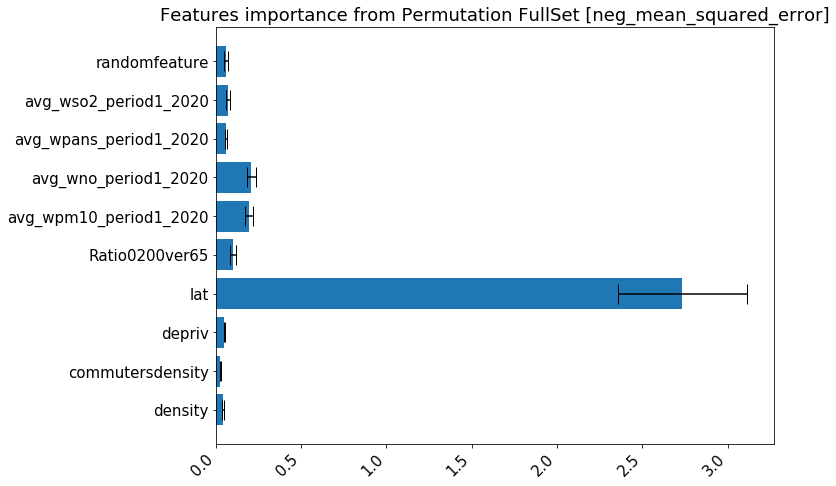

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.01972 +/- 0.00186
Feature:               commutersdensity, Score: 0.01207 +/- 0.00121
Feature:                         depriv, Score: 0.02322 +/- 0.00200
Feature:                            lat, Score: 1.25185 +/- 0.17332
Feature:                 Ratio0200ver65, Score: 0.04689 +/- 0.00783
Feature:         avg_wpm10_period1_2020, Score: 0.08863 +/- 0.01061
Feature:           avg_wno_period1_2020, Score: 0.09587 +/- 0.01249
Feature:         avg_wpans_period1_2020, Score: 0.02712 +/- 0.00343
Feature:          avg_wso2_period1_2020, Score: 0.03190 +/- 0.00537
Feature:                  randomfeature, Score: 0.02751 +/- 0.00442


<Figure size 432x288 with 0 Axes>

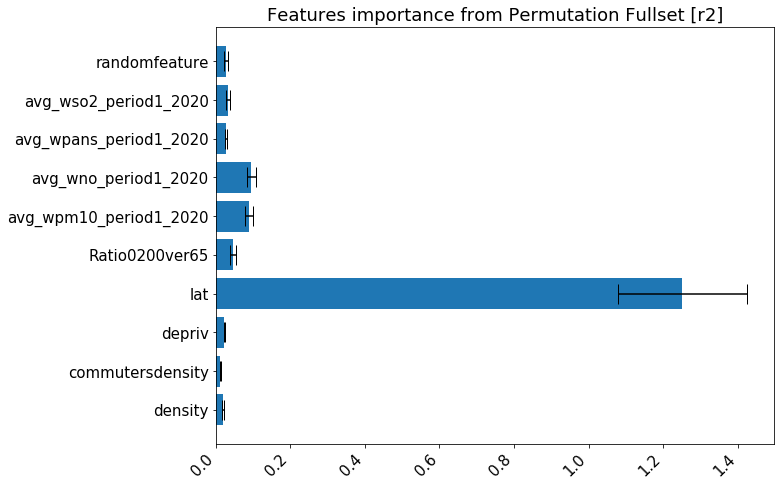

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01755 +/- 0.02117
Feature:               commutersdensity, Score: -0.02146 +/- 0.01892
Feature:                         depriv, Score: 0.00156 +/- 0.02483
Feature:                            lat, Score: 2.17740 +/- 0.69775
Feature:                 Ratio0200ver65, Score: 0.00636 +/- 0.05825
Feature:         avg_wpm10_period1_2020, Score: -0.03788 +/- 0.04462
Feature:           avg_wno_period1_2020, Score: 0.01885 +/- 0.04105
Feature:         avg_wpans_period1_2020, Score: 0.02119 +/- 0.02129
Feature:          avg_wso2_period1_2020, Score: 0.01498 +/- 0.05476
Feature:                  randomfeature, Score: -0.00640 +/- 0.02905


<Figure size 432x288 with 0 Axes>

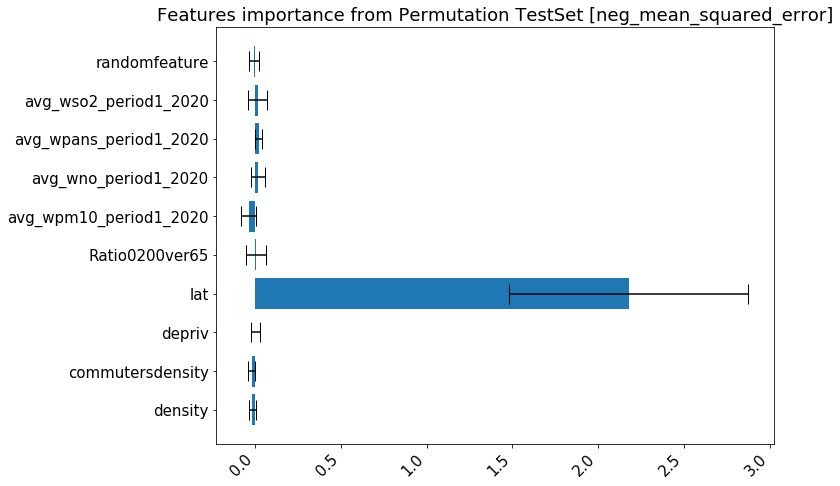

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01199 +/- 0.01447
Feature:               commutersdensity, Score: -0.01467 +/- 0.01293
Feature:                         depriv, Score: 0.00107 +/- 0.01697
Feature:                            lat, Score: 1.48809 +/- 0.47686
Feature:                 Ratio0200ver65, Score: 0.00434 +/- 0.03981
Feature:         avg_wpm10_period1_2020, Score: -0.02589 +/- 0.03050
Feature:           avg_wno_period1_2020, Score: 0.01288 +/- 0.02806
Feature:         avg_wpans_period1_2020, Score: 0.01448 +/- 0.01455
Feature:          avg_wso2_period1_2020, Score: 0.01024 +/- 0.03742
Feature:                  randomfeature, Score: -0.00437 +/- 0.01986


<Figure size 432x288 with 0 Axes>

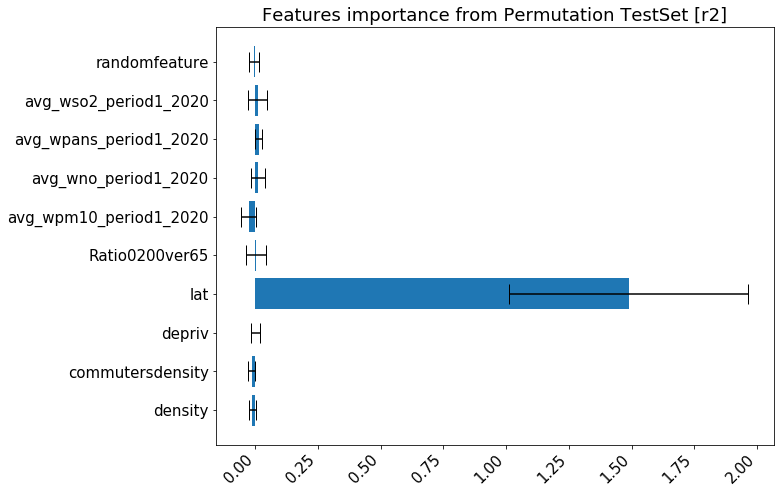

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04397 +/- 0.00804
Feature:               commutersdensity, Score: 0.03777 +/- 0.00498
Feature:                         depriv, Score: 0.04903 +/- 0.00688
Feature:                            lat, Score: 3.11647 +/- 0.43069
Feature:                 Ratio0200ver65, Score: 0.12021 +/- 0.02190
Feature:         avg_wpm10_period1_2020, Score: 0.26930 +/- 0.04031
Feature:           avg_wno_period1_2020, Score: 0.10143 +/- 0.01269
Feature:         avg_wpans_period1_2020, Score: 0.04669 +/- 0.00586
Feature:          avg_wso2_period1_2020, Score: 0.10139 +/- 0.02077
Feature:                  randomfeature, Score: 0.06549 +/- 0.01101


<Figure size 432x288 with 0 Axes>

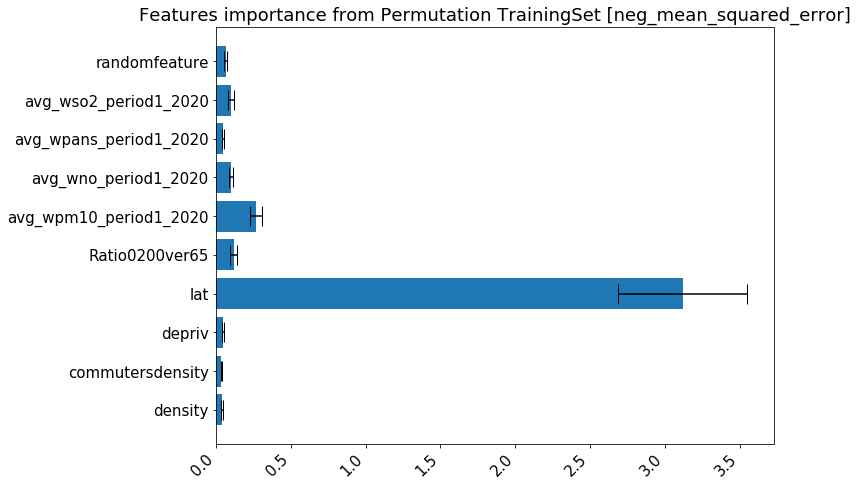

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.01863 +/- 0.00341
Feature:               commutersdensity, Score: 0.01600 +/- 0.00211
Feature:                         depriv, Score: 0.02078 +/- 0.00291
Feature:                            lat, Score: 1.32050 +/- 0.18249
Feature:                 Ratio0200ver65, Score: 0.05094 +/- 0.00928
Feature:         avg_wpm10_period1_2020, Score: 0.11411 +/- 0.01708
Feature:           avg_wno_period1_2020, Score: 0.04298 +/- 0.00538
Feature:         avg_wpans_period1_2020, Score: 0.01978 +/- 0.00248
Feature:          avg_wso2_period1_2020, Score: 0.04296 +/- 0.00880
Feature:                  randomfeature, Score: 0.02775 +/- 0.00467


<Figure size 432x288 with 0 Axes>

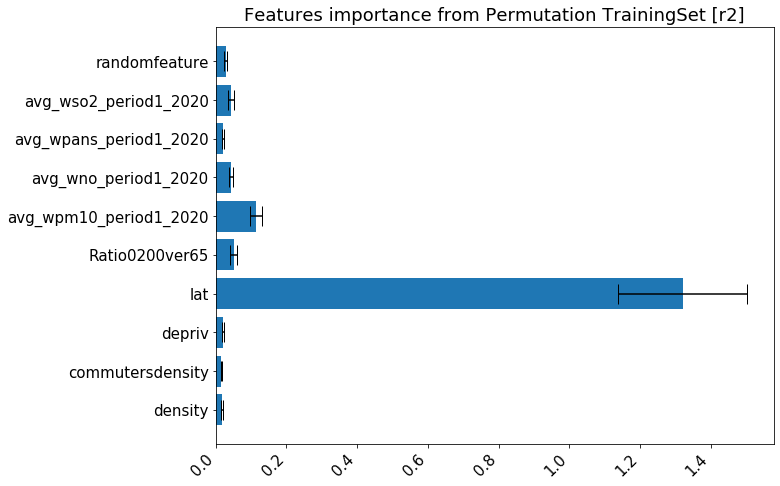

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_rmse)
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_optallset", showplot=True, optimisedparams=besthyperF)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37148  0.02574 
    Test set average RMSE:  1.02434  0.10905 

Prediction STD :  1.2572667279303062
True value STD:   1.4782591096169262
Difference in percentage:  14.949502441685446

             Fullset RMSE:  0.36288
                       R2:  0.93974


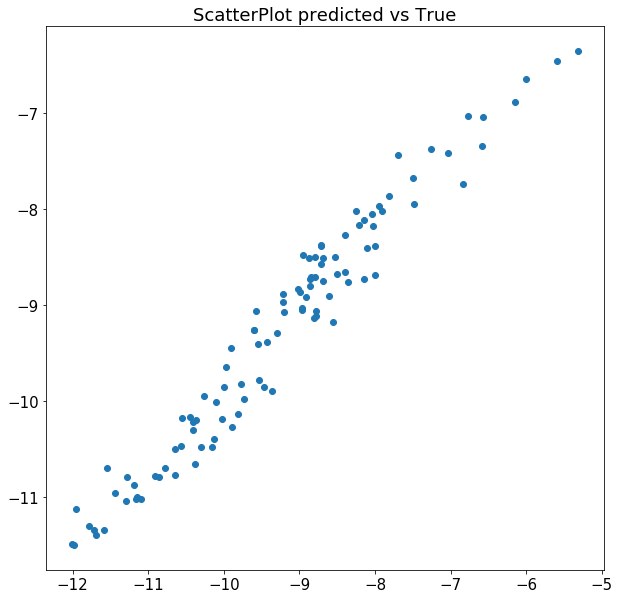

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04600 +/- 0.00568
Feature:               commutersdensity, Score: 1.72975 +/- 0.26373
Feature:                         depriv, Score: 0.06526 +/- 0.00841
Feature:                 Ratio0200ver65, Score: 0.21842 +/- 0.02651
Feature:         avg_wpm10_period1_2020, Score: 0.25170 +/- 0.03441
Feature:           avg_wno_period1_2020, Score: 0.36431 +/- 0.04217
Feature:         avg_wpans_period1_2020, Score: 0.08395 +/- 0.01219
Feature:          avg_wso2_period1_2020, Score: 0.10452 +/- 0.01346
Feature:                  randomfeature, Score: 0.06097 +/- 0.00792


<Figure size 432x288 with 0 Axes>

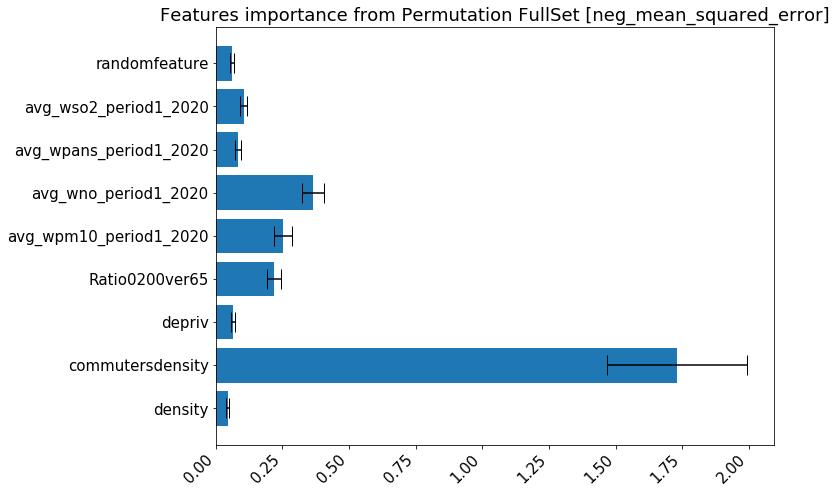

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02105 +/- 0.00260
Feature:               commutersdensity, Score: 0.79156 +/- 0.12069
Feature:                         depriv, Score: 0.02986 +/- 0.00385
Feature:                 Ratio0200ver65, Score: 0.09995 +/- 0.01213
Feature:         avg_wpm10_period1_2020, Score: 0.11518 +/- 0.01575
Feature:           avg_wno_period1_2020, Score: 0.16672 +/- 0.01930
Feature:         avg_wpans_period1_2020, Score: 0.03842 +/- 0.00558
Feature:          avg_wso2_period1_2020, Score: 0.04783 +/- 0.00616
Feature:                  randomfeature, Score: 0.02790 +/- 0.00362


<Figure size 432x288 with 0 Axes>

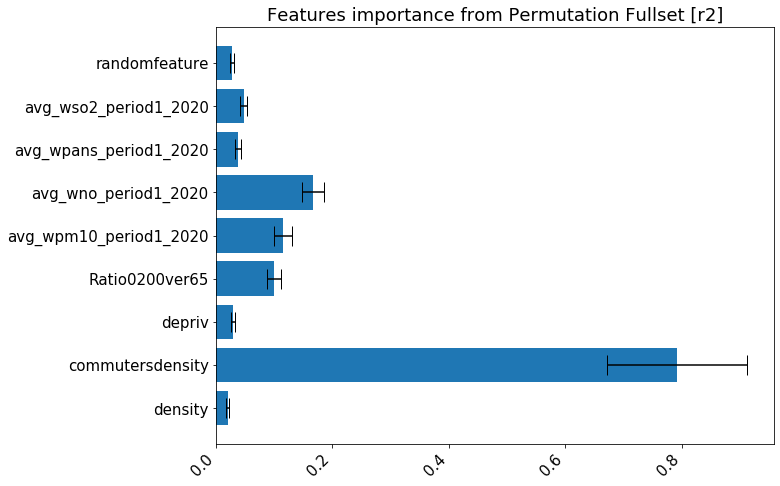

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00191 +/- 0.01938
Feature:               commutersdensity, Score: 1.17092 +/- 0.45391
Feature:                         depriv, Score: 0.00055 +/- 0.02845
Feature:                 Ratio0200ver65, Score: 0.12438 +/- 0.08424
Feature:         avg_wpm10_period1_2020, Score: -0.02793 +/- 0.07735
Feature:           avg_wno_period1_2020, Score: 0.03955 +/- 0.06609
Feature:         avg_wpans_period1_2020, Score: 0.01810 +/- 0.02596
Feature:          avg_wso2_period1_2020, Score: -0.02897 +/- 0.04208
Feature:                  randomfeature, Score: -0.01906 +/- 0.02292


<Figure size 432x288 with 0 Axes>

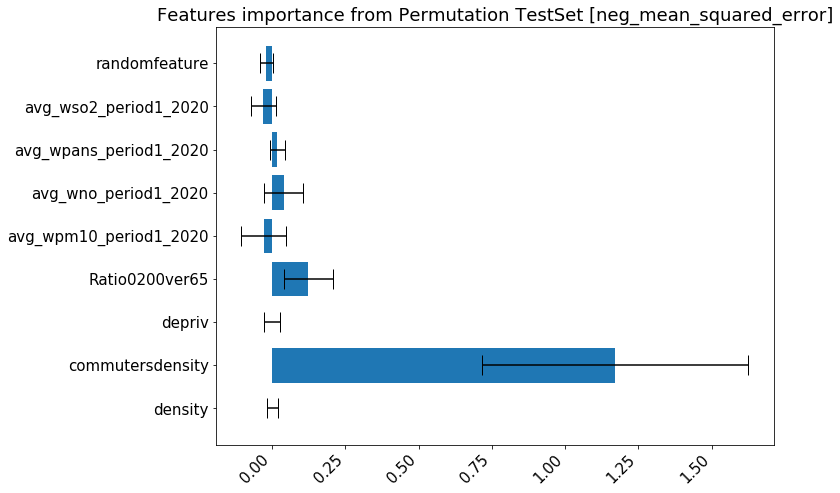

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00131 +/- 0.01325
Feature:               commutersdensity, Score: 0.80024 +/- 0.31021
Feature:                         depriv, Score: 0.00038 +/- 0.01944
Feature:                 Ratio0200ver65, Score: 0.08500 +/- 0.05757
Feature:         avg_wpm10_period1_2020, Score: -0.01909 +/- 0.05287
Feature:           avg_wno_period1_2020, Score: 0.02703 +/- 0.04517
Feature:         avg_wpans_period1_2020, Score: 0.01237 +/- 0.01774
Feature:          avg_wso2_period1_2020, Score: -0.01980 +/- 0.02876
Feature:                  randomfeature, Score: -0.01303 +/- 0.01566


<Figure size 432x288 with 0 Axes>

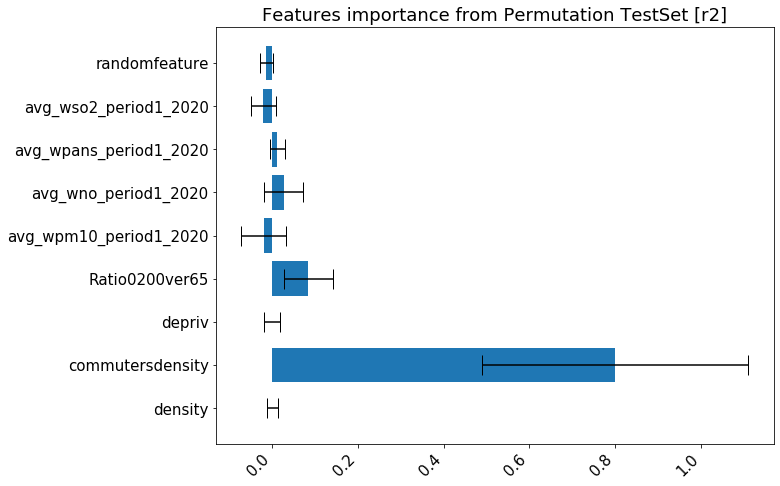

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06628 +/- 0.00765
Feature:               commutersdensity, Score: 1.96583 +/- 0.33915
Feature:                         depriv, Score: 0.06089 +/- 0.00909
Feature:                 Ratio0200ver65, Score: 0.24884 +/- 0.03445
Feature:         avg_wpm10_period1_2020, Score: 0.36367 +/- 0.05736
Feature:           avg_wno_period1_2020, Score: 0.22017 +/- 0.03016
Feature:         avg_wpans_period1_2020, Score: 0.08085 +/- 0.01188
Feature:          avg_wso2_period1_2020, Score: 0.12500 +/- 0.01874
Feature:                  randomfeature, Score: 0.05050 +/- 0.00691


<Figure size 432x288 with 0 Axes>

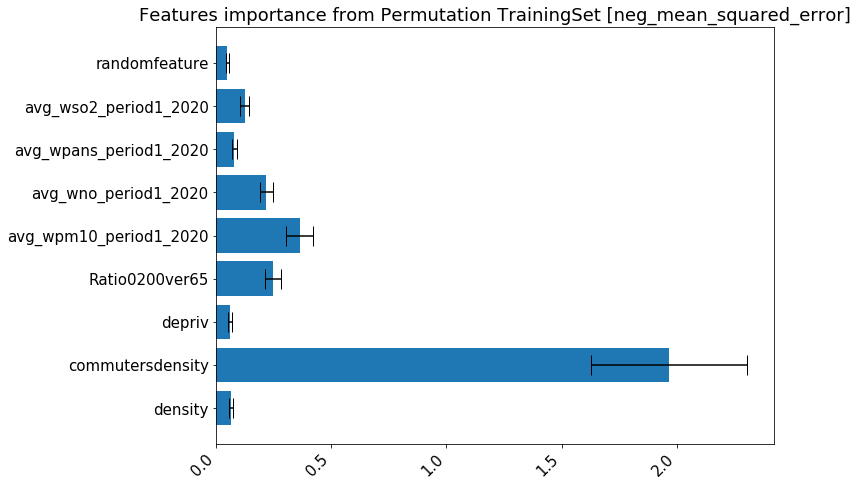

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02808 +/- 0.00324
Feature:               commutersdensity, Score: 0.83296 +/- 0.14370
Feature:                         depriv, Score: 0.02580 +/- 0.00385
Feature:                 Ratio0200ver65, Score: 0.10544 +/- 0.01460
Feature:         avg_wpm10_period1_2020, Score: 0.15409 +/- 0.02430
Feature:           avg_wno_period1_2020, Score: 0.09329 +/- 0.01278
Feature:         avg_wpans_period1_2020, Score: 0.03426 +/- 0.00503
Feature:          avg_wso2_period1_2020, Score: 0.05296 +/- 0.00794
Feature:                  randomfeature, Score: 0.02140 +/- 0.00293


<Figure size 432x288 with 0 Axes>

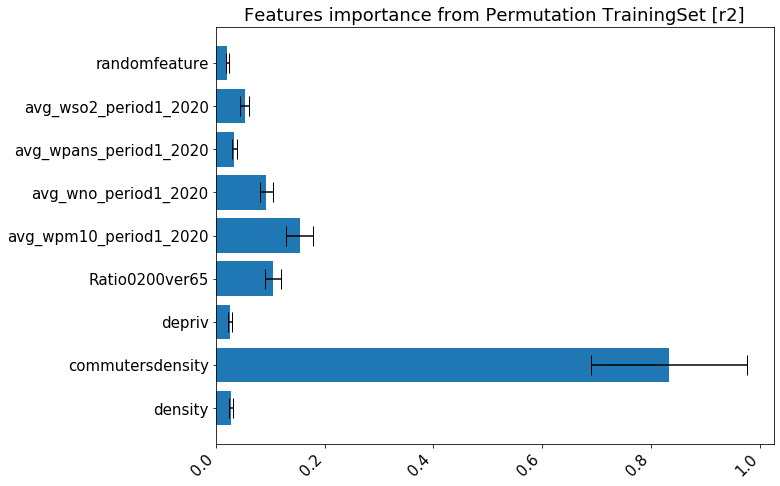

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_rmse)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_optallset", showplot=True, optimisedparams=besthyperF )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38904  0.02136 
    Test set average RMSE:  1.09684  0.09351 

Prediction STD :  1.2209764146976128
True value STD:   1.4782591096169262
Difference in percentage:  17.404438318393673

             Fullset RMSE:  0.38343
                       R2:  0.93272


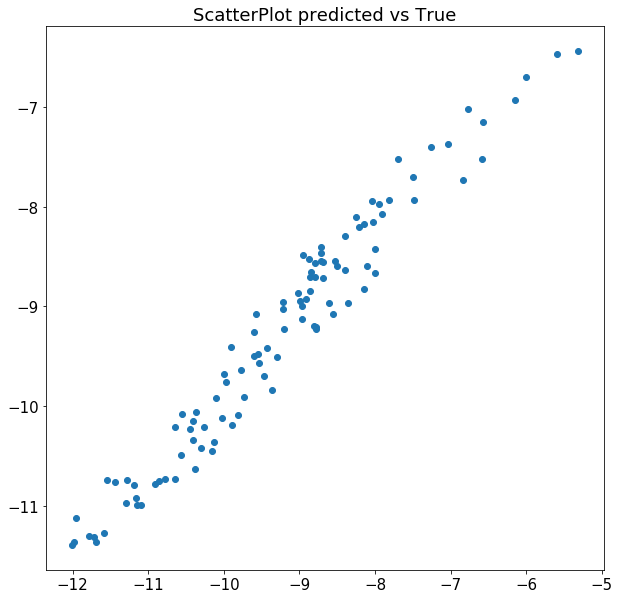

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07182 +/- 0.00852
Feature:                         depriv, Score: 0.64040 +/- 0.10256
Feature:                 Ratio0200ver65, Score: 0.16776 +/- 0.02468
Feature:         avg_wpm10_period1_2020, Score: 0.38428 +/- 0.04671
Feature:           avg_wno_period1_2020, Score: 0.96999 +/- 0.12707
Feature:         avg_wpans_period1_2020, Score: 0.14362 +/- 0.01831
Feature:          avg_wso2_period1_2020, Score: 0.08961 +/- 0.00923
Feature:                  randomfeature, Score: 0.08085 +/- 0.01249


<Figure size 432x288 with 0 Axes>

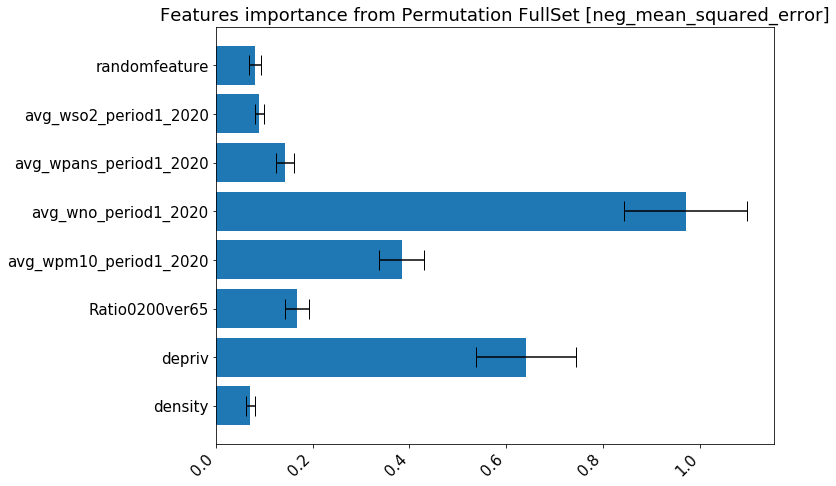

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.03286 +/- 0.00390
Feature:                         depriv, Score: 0.29306 +/- 0.04693
Feature:                 Ratio0200ver65, Score: 0.07677 +/- 0.01129
Feature:         avg_wpm10_period1_2020, Score: 0.17585 +/- 0.02137
Feature:           avg_wno_period1_2020, Score: 0.44388 +/- 0.05815
Feature:         avg_wpans_period1_2020, Score: 0.06572 +/- 0.00838
Feature:          avg_wso2_period1_2020, Score: 0.04101 +/- 0.00422
Feature:                  randomfeature, Score: 0.03700 +/- 0.00572


<Figure size 432x288 with 0 Axes>

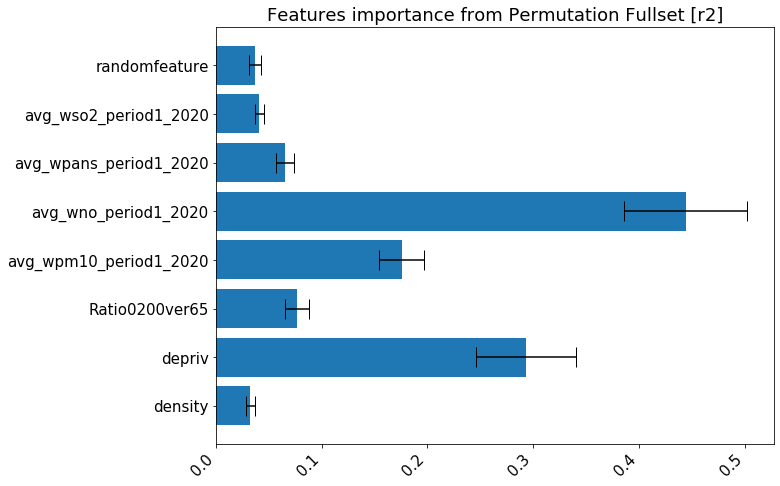

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00579 +/- 0.01648
Feature:                         depriv, Score: 0.40347 +/- 0.15360
Feature:                 Ratio0200ver65, Score: 0.05041 +/- 0.05303
Feature:         avg_wpm10_period1_2020, Score: 0.00121 +/- 0.06271
Feature:           avg_wno_period1_2020, Score: 0.41446 +/- 0.16081
Feature:         avg_wpans_period1_2020, Score: 0.03749 +/- 0.04628
Feature:          avg_wso2_period1_2020, Score: -0.00100 +/- 0.05212
Feature:                  randomfeature, Score: -0.00379 +/- 0.01455


<Figure size 432x288 with 0 Axes>

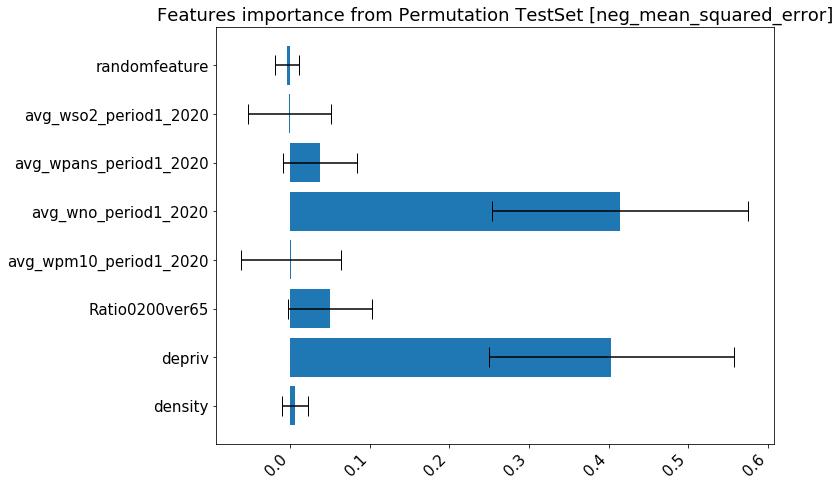

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00396 +/- 0.01126
Feature:                         depriv, Score: 0.27574 +/- 0.10497
Feature:                 Ratio0200ver65, Score: 0.03445 +/- 0.03624
Feature:         avg_wpm10_period1_2020, Score: 0.00083 +/- 0.04286
Feature:           avg_wno_period1_2020, Score: 0.28325 +/- 0.10990
Feature:         avg_wpans_period1_2020, Score: 0.02562 +/- 0.03163
Feature:          avg_wso2_period1_2020, Score: -0.00068 +/- 0.03562
Feature:                  randomfeature, Score: -0.00259 +/- 0.00994


<Figure size 432x288 with 0 Axes>

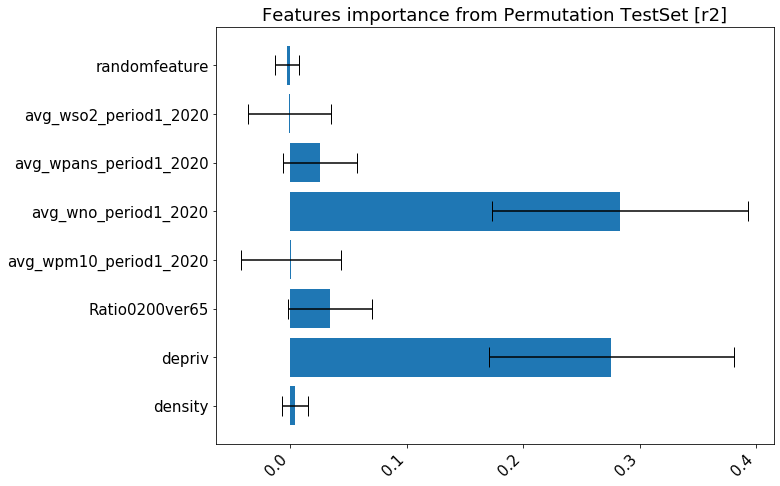

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06418 +/- 0.00963
Feature:                         depriv, Score: 0.68711 +/- 0.11703
Feature:                 Ratio0200ver65, Score: 0.16836 +/- 0.02414
Feature:         avg_wpm10_period1_2020, Score: 0.49655 +/- 0.07479
Feature:           avg_wno_period1_2020, Score: 1.03465 +/- 0.16616
Feature:         avg_wpans_period1_2020, Score: 0.13439 +/- 0.01986
Feature:          avg_wso2_period1_2020, Score: 0.18075 +/- 0.02544
Feature:                  randomfeature, Score: 0.06383 +/- 0.00695


<Figure size 432x288 with 0 Axes>

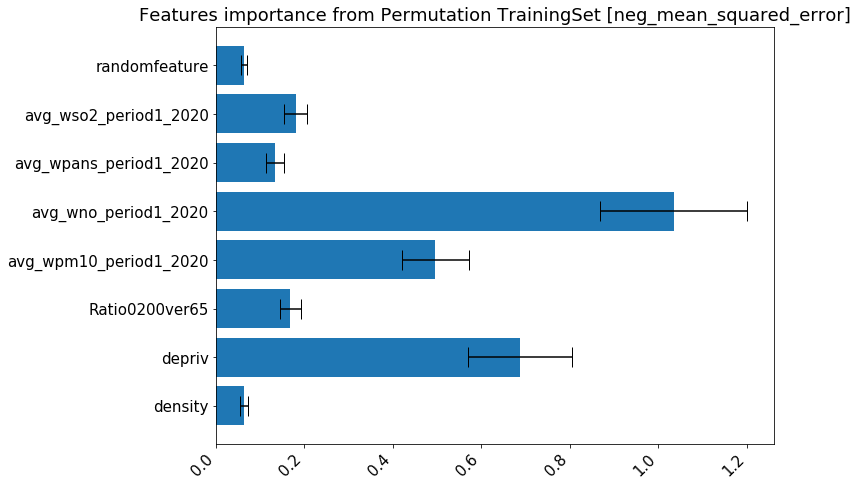

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02719 +/- 0.00408
Feature:                         depriv, Score: 0.29114 +/- 0.04959
Feature:                 Ratio0200ver65, Score: 0.07134 +/- 0.01023
Feature:         avg_wpm10_period1_2020, Score: 0.21040 +/- 0.03169
Feature:           avg_wno_period1_2020, Score: 0.43840 +/- 0.07040
Feature:         avg_wpans_period1_2020, Score: 0.05694 +/- 0.00842
Feature:          avg_wso2_period1_2020, Score: 0.07659 +/- 0.01078
Feature:                  randomfeature, Score: 0.02705 +/- 0.00295


<Figure size 432x288 with 0 Axes>

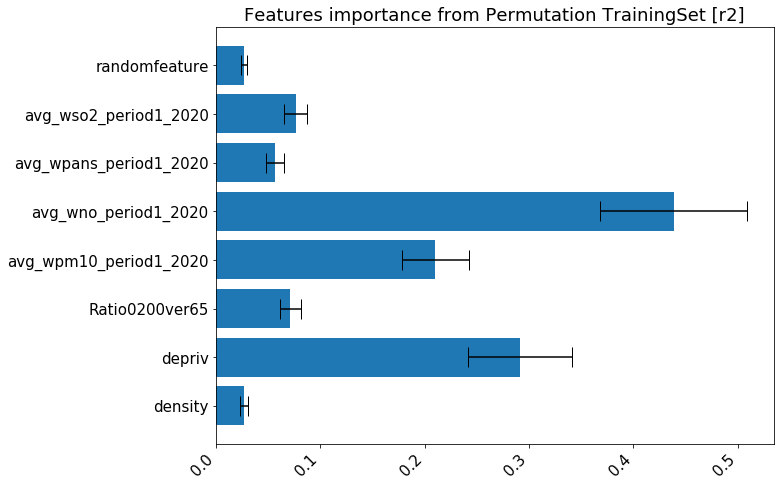

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_rmse)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_optallset", showplot=True, optimisedparams=besthyperF)

Qui invece ottimizzado RMSE sul testset

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.41460  0.02230 
    Test set average RMSE:  0.95217  0.08674 

Prediction STD :  1.3016361039469773
True value STD:   1.4782591096169262
Difference in percentage:  11.948041078922811

             Fullset RMSE:  0.40828
                       R2:  0.92372


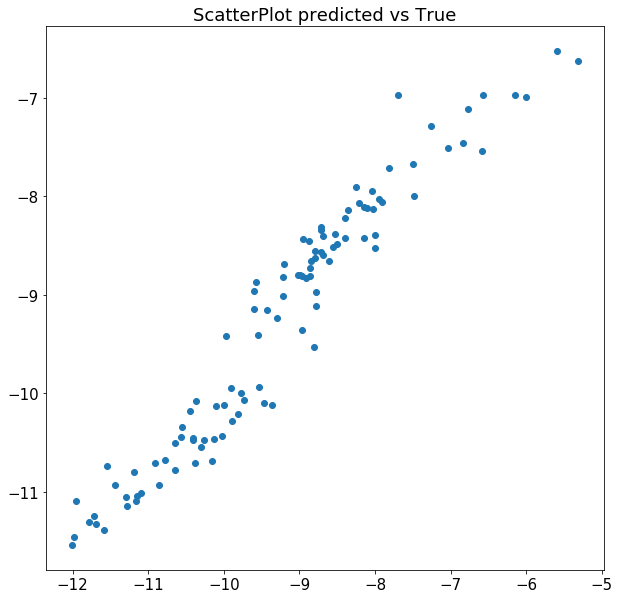

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04933 +/- 0.00537
Feature:               commutersdensity, Score: 0.02827 +/- 0.00307
Feature:                         depriv, Score: 0.04978 +/- 0.00449
Feature:                            lat, Score: 2.70956 +/- 0.37638
Feature:                 Ratio0200ver65, Score: 0.13111 +/- 0.02367
Feature:         avg_wpm10_period1_2020, Score: 0.17436 +/- 0.01949
Feature:           avg_wno_period1_2020, Score: 0.19490 +/- 0.02800
Feature:         avg_wpans_period1_2020, Score: 0.05331 +/- 0.00656
Feature:          avg_wso2_period1_2020, Score: 0.07280 +/- 0.01098
Feature:                  randomfeature, Score: 0.07214 +/- 0.01354


<Figure size 432x288 with 0 Axes>

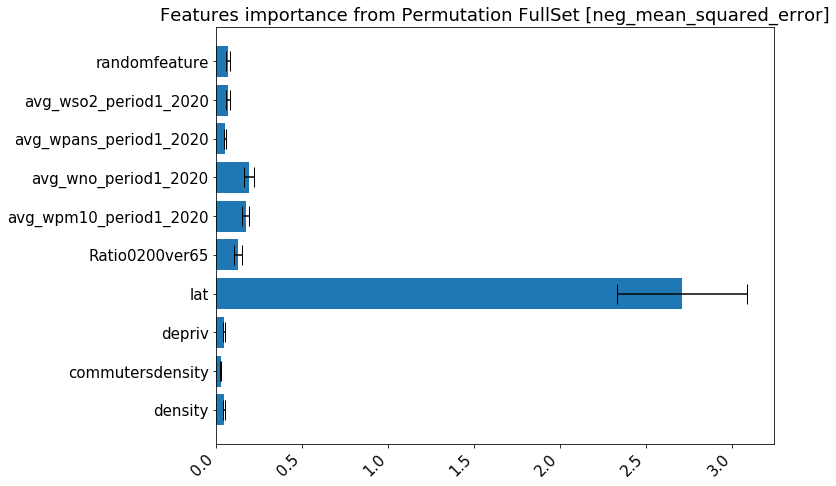

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02257 +/- 0.00246
Feature:               commutersdensity, Score: 0.01294 +/- 0.00141
Feature:                         depriv, Score: 0.02278 +/- 0.00206
Feature:                            lat, Score: 1.23993 +/- 0.17224
Feature:                 Ratio0200ver65, Score: 0.06000 +/- 0.01083
Feature:         avg_wpm10_period1_2020, Score: 0.07979 +/- 0.00892
Feature:           avg_wno_period1_2020, Score: 0.08919 +/- 0.01281
Feature:         avg_wpans_period1_2020, Score: 0.02439 +/- 0.00300
Feature:          avg_wso2_period1_2020, Score: 0.03332 +/- 0.00503
Feature:                  randomfeature, Score: 0.03301 +/- 0.00620


<Figure size 432x288 with 0 Axes>

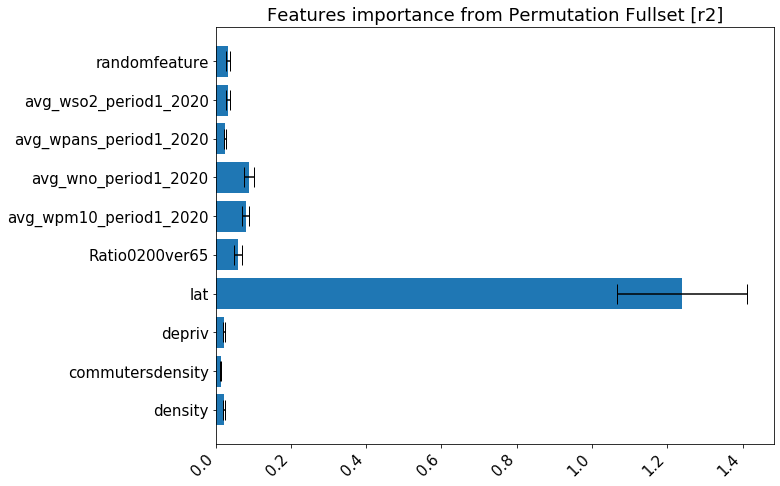

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01667 +/- 0.02264
Feature:               commutersdensity, Score: -0.00127 +/- 0.01679
Feature:                         depriv, Score: 0.01781 +/- 0.02551
Feature:                            lat, Score: 1.82388 +/- 0.59483
Feature:                 Ratio0200ver65, Score: 0.03424 +/- 0.05907
Feature:         avg_wpm10_period1_2020, Score: -0.04961 +/- 0.05514
Feature:           avg_wno_period1_2020, Score: 0.02978 +/- 0.03910
Feature:         avg_wpans_period1_2020, Score: -0.00839 +/- 0.02433
Feature:          avg_wso2_period1_2020, Score: 0.02826 +/- 0.05804
Feature:                  randomfeature, Score: 0.00380 +/- 0.02290


<Figure size 432x288 with 0 Axes>

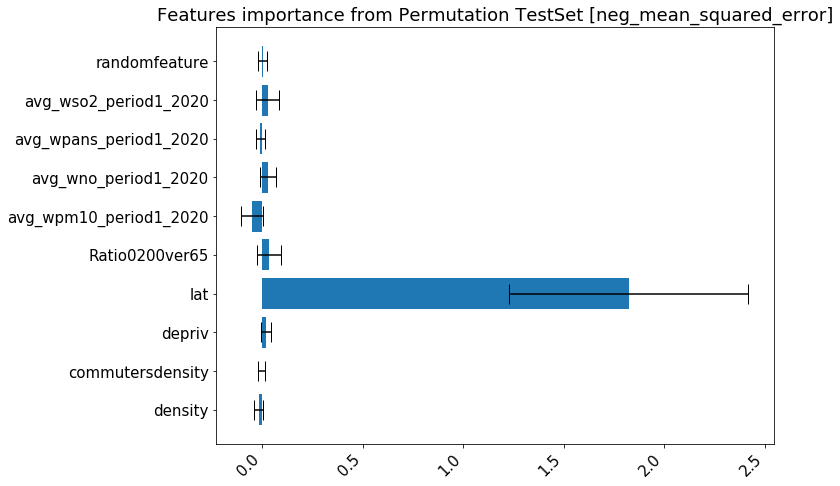

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01139 +/- 0.01547
Feature:               commutersdensity, Score: -0.00087 +/- 0.01147
Feature:                         depriv, Score: 0.01217 +/- 0.01744
Feature:                            lat, Score: 1.24649 +/- 0.40652
Feature:                 Ratio0200ver65, Score: 0.02340 +/- 0.04037
Feature:         avg_wpm10_period1_2020, Score: -0.03391 +/- 0.03768
Feature:           avg_wno_period1_2020, Score: 0.02035 +/- 0.02672
Feature:         avg_wpans_period1_2020, Score: -0.00573 +/- 0.01663
Feature:          avg_wso2_period1_2020, Score: 0.01932 +/- 0.03966
Feature:                  randomfeature, Score: 0.00260 +/- 0.01565


<Figure size 432x288 with 0 Axes>

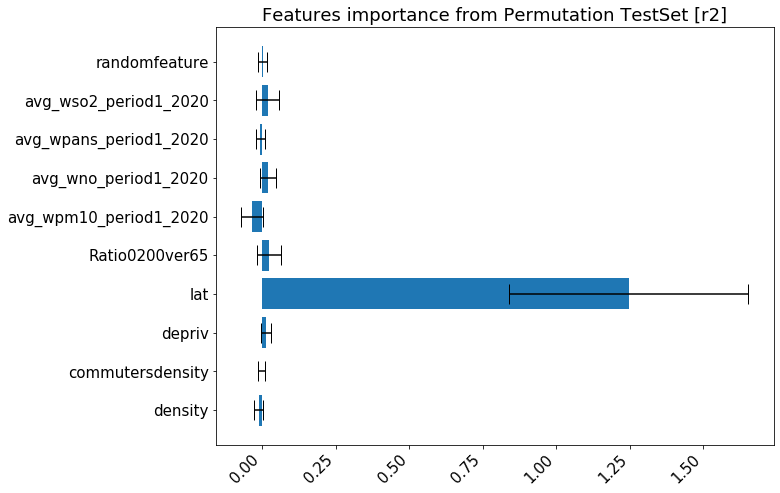

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04135 +/- 0.00990
Feature:               commutersdensity, Score: 0.02754 +/- 0.00434
Feature:                         depriv, Score: 0.05757 +/- 0.00811
Feature:                            lat, Score: 2.82300 +/- 0.39600
Feature:                 Ratio0200ver65, Score: 0.12343 +/- 0.02382
Feature:         avg_wpm10_period1_2020, Score: 0.32249 +/- 0.04457
Feature:           avg_wno_period1_2020, Score: 0.09332 +/- 0.01346
Feature:         avg_wpans_period1_2020, Score: 0.04491 +/- 0.00505
Feature:          avg_wso2_period1_2020, Score: 0.12058 +/- 0.02255
Feature:                  randomfeature, Score: 0.04100 +/- 0.00617


<Figure size 432x288 with 0 Axes>

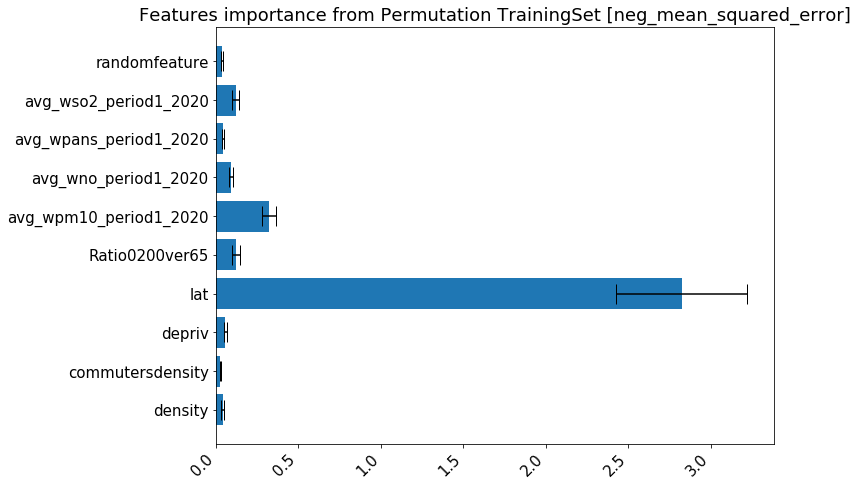

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.01752 +/- 0.00419
Feature:               commutersdensity, Score: 0.01167 +/- 0.00184
Feature:                         depriv, Score: 0.02439 +/- 0.00343
Feature:                            lat, Score: 1.19616 +/- 0.16779
Feature:                 Ratio0200ver65, Score: 0.05230 +/- 0.01009
Feature:         avg_wpm10_period1_2020, Score: 0.13665 +/- 0.01888
Feature:           avg_wno_period1_2020, Score: 0.03954 +/- 0.00570
Feature:         avg_wpans_period1_2020, Score: 0.01903 +/- 0.00214
Feature:          avg_wso2_period1_2020, Score: 0.05109 +/- 0.00955
Feature:                  randomfeature, Score: 0.01737 +/- 0.00262


<Figure size 432x288 with 0 Axes>

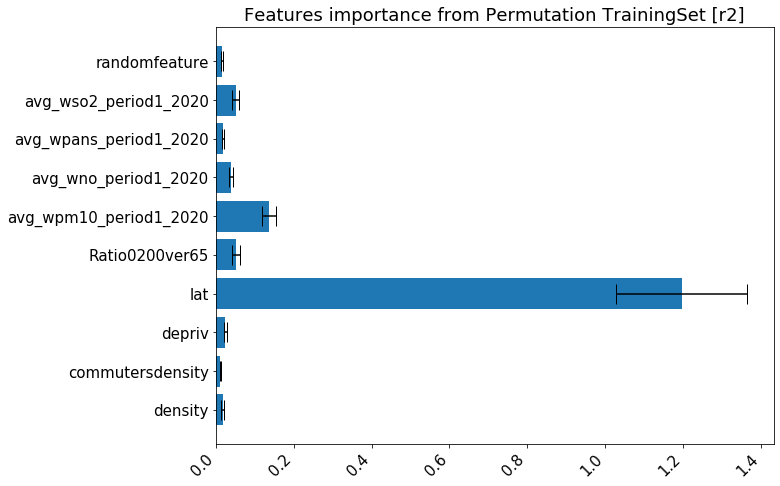

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_opttestset", showplot=True, optimisedparams=besthyperF)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.43215  0.02917 
    Test set average RMSE:  1.05124  0.09983 

Prediction STD :  1.2319965964689656
True value STD:   1.4782591096169262
Difference in percentage:  16.658954546322846

             Fullset RMSE:  0.48233
                       R2:  0.89354


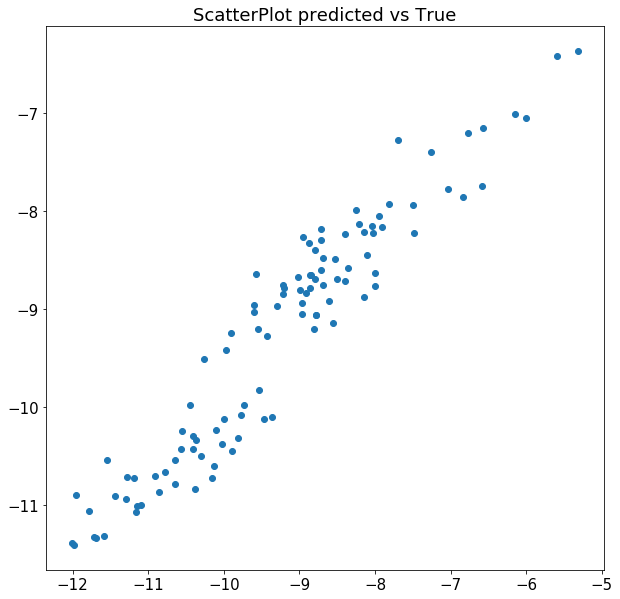

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05833 +/- 0.00627
Feature:               commutersdensity, Score: 1.61281 +/- 0.24762
Feature:                         depriv, Score: 0.07041 +/- 0.01091
Feature:                 Ratio0200ver65, Score: 0.21146 +/- 0.02865
Feature:         avg_wpm10_period1_2020, Score: 0.28060 +/- 0.03714
Feature:           avg_wno_period1_2020, Score: 0.35491 +/- 0.04655
Feature:         avg_wpans_period1_2020, Score: 0.07569 +/- 0.01134
Feature:          avg_wso2_period1_2020, Score: 0.09424 +/- 0.01160
Feature:                  randomfeature, Score: 0.06808 +/- 0.00774


<Figure size 432x288 with 0 Axes>

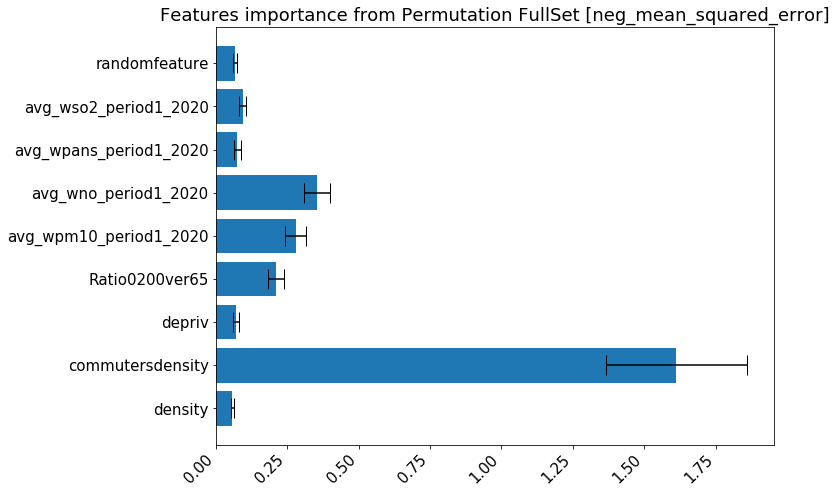

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02669 +/- 0.00287
Feature:               commutersdensity, Score: 0.73805 +/- 0.11331
Feature:                         depriv, Score: 0.03222 +/- 0.00499
Feature:                 Ratio0200ver65, Score: 0.09677 +/- 0.01311
Feature:         avg_wpm10_period1_2020, Score: 0.12841 +/- 0.01700
Feature:           avg_wno_period1_2020, Score: 0.16241 +/- 0.02130
Feature:         avg_wpans_period1_2020, Score: 0.03464 +/- 0.00519
Feature:          avg_wso2_period1_2020, Score: 0.04313 +/- 0.00531
Feature:                  randomfeature, Score: 0.03115 +/- 0.00354


<Figure size 432x288 with 0 Axes>

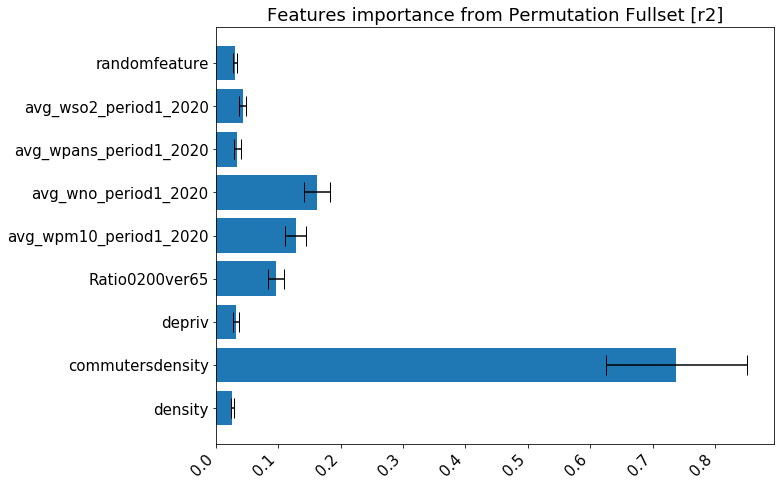

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00193 +/- 0.01739
Feature:               commutersdensity, Score: 1.24249 +/- 0.47845
Feature:                         depriv, Score: -0.01692 +/- 0.03679
Feature:                 Ratio0200ver65, Score: 0.06433 +/- 0.06316
Feature:         avg_wpm10_period1_2020, Score: -0.04630 +/- 0.05302
Feature:           avg_wno_period1_2020, Score: 0.04271 +/- 0.06838
Feature:         avg_wpans_period1_2020, Score: 0.00191 +/- 0.02470
Feature:          avg_wso2_period1_2020, Score: -0.02496 +/- 0.06205
Feature:                  randomfeature, Score: -0.01302 +/- 0.01677


<Figure size 432x288 with 0 Axes>

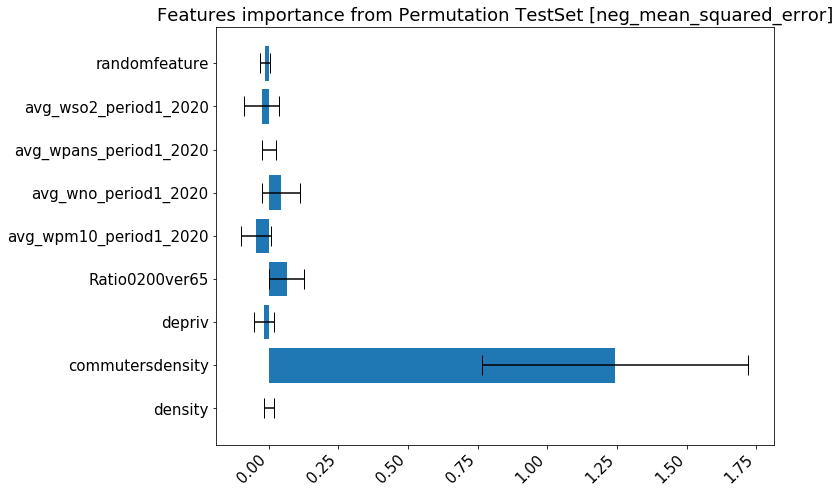

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00132 +/- 0.01189
Feature:               commutersdensity, Score: 0.84915 +/- 0.32698
Feature:                         depriv, Score: -0.01156 +/- 0.02514
Feature:                 Ratio0200ver65, Score: 0.04396 +/- 0.04317
Feature:         avg_wpm10_period1_2020, Score: -0.03164 +/- 0.03624
Feature:           avg_wno_period1_2020, Score: 0.02919 +/- 0.04673
Feature:         avg_wpans_period1_2020, Score: 0.00131 +/- 0.01688
Feature:          avg_wso2_period1_2020, Score: -0.01706 +/- 0.04241
Feature:                  randomfeature, Score: -0.00890 +/- 0.01146


<Figure size 432x288 with 0 Axes>

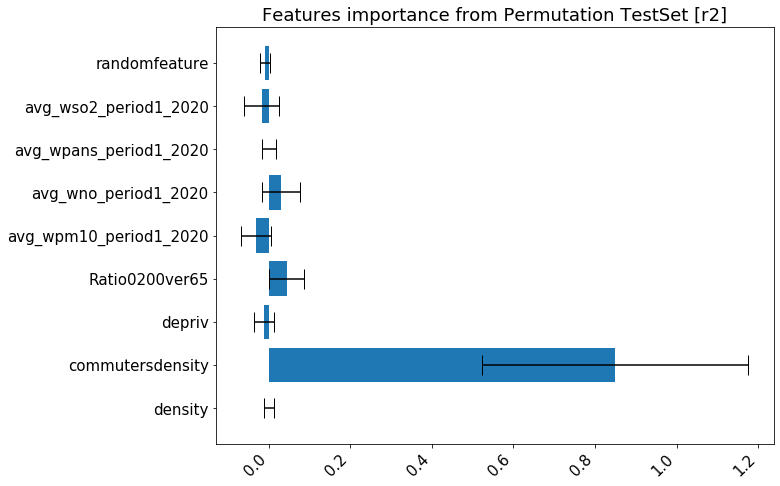

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04402 +/- 0.00637
Feature:               commutersdensity, Score: 1.94320 +/- 0.33528
Feature:                         depriv, Score: 0.08119 +/- 0.01147
Feature:                 Ratio0200ver65, Score: 0.19713 +/- 0.02528
Feature:         avg_wpm10_period1_2020, Score: 0.33609 +/- 0.05029
Feature:           avg_wno_period1_2020, Score: 0.22800 +/- 0.03155
Feature:         avg_wpans_period1_2020, Score: 0.07832 +/- 0.01280
Feature:          avg_wso2_period1_2020, Score: 0.17943 +/- 0.02887
Feature:                  randomfeature, Score: 0.04101 +/- 0.00611


<Figure size 432x288 with 0 Axes>

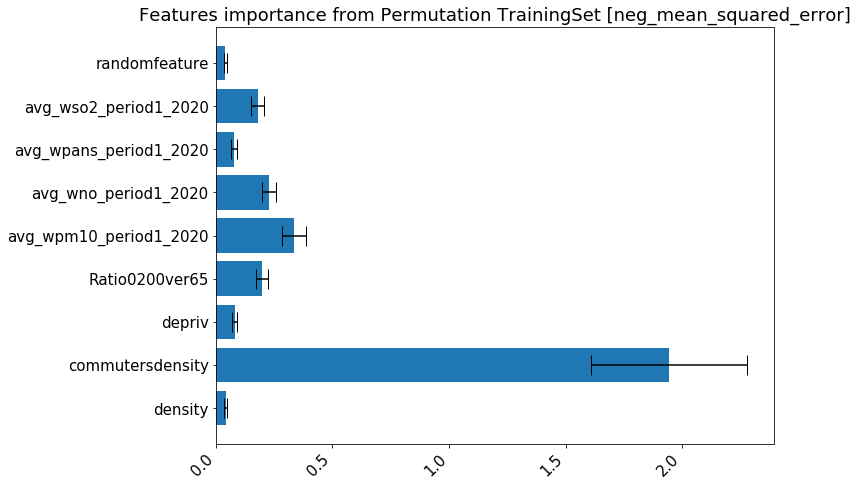

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.01865 +/- 0.00270
Feature:               commutersdensity, Score: 0.82337 +/- 0.14206
Feature:                         depriv, Score: 0.03440 +/- 0.00486
Feature:                 Ratio0200ver65, Score: 0.08353 +/- 0.01071
Feature:         avg_wpm10_period1_2020, Score: 0.14241 +/- 0.02131
Feature:           avg_wno_period1_2020, Score: 0.09661 +/- 0.01337
Feature:         avg_wpans_period1_2020, Score: 0.03319 +/- 0.00542
Feature:          avg_wso2_period1_2020, Score: 0.07603 +/- 0.01223
Feature:                  randomfeature, Score: 0.01738 +/- 0.00259


<Figure size 432x288 with 0 Axes>

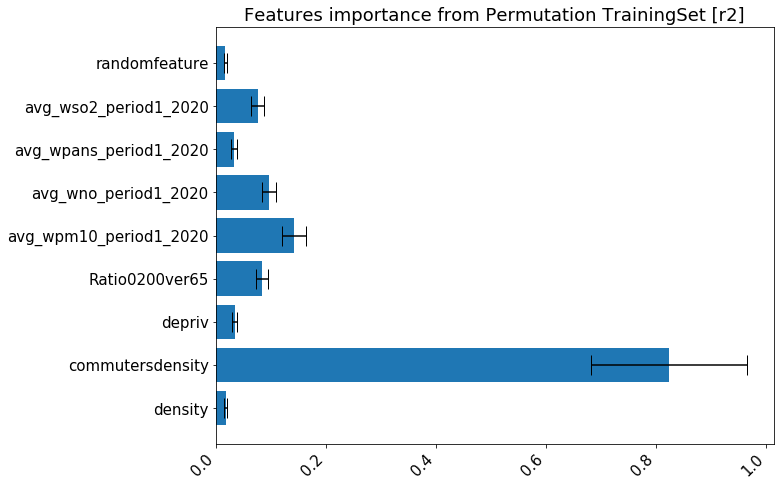

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_opttestset", showplot=True, optimisedparams=besthyperF )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.77763  0.04455 
    Test set average RMSE:  1.09107  0.12125 

Prediction STD :  1.0955001876022419
True value STD:   1.4782591096169262
Difference in percentage:  25.892546139213163

             Fullset RMSE:  0.71749
                       R2:  0.76442


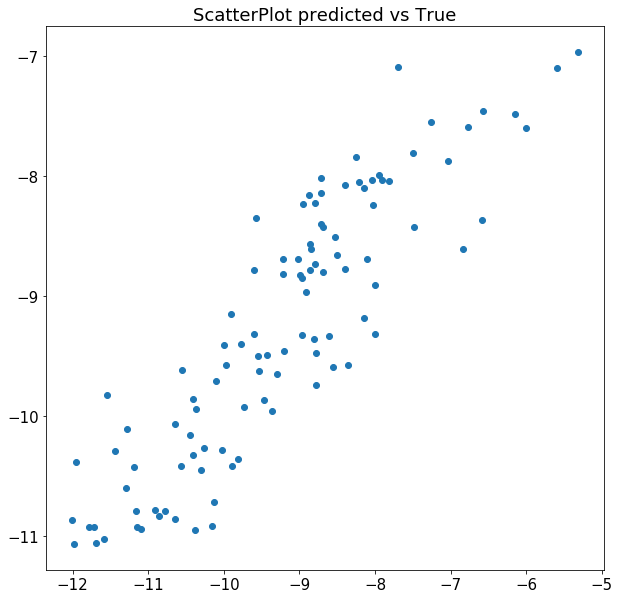

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05476 +/- 0.00885
Feature:                         depriv, Score: 0.63819 +/- 0.10535
Feature:                 Ratio0200ver65, Score: 0.17688 +/- 0.02576
Feature:         avg_wpm10_period1_2020, Score: 0.43967 +/- 0.05812
Feature:           avg_wno_period1_2020, Score: 0.84296 +/- 0.10395
Feature:         avg_wpans_period1_2020, Score: 0.13470 +/- 0.01729
Feature:          avg_wso2_period1_2020, Score: 0.10538 +/- 0.01274
Feature:                  randomfeature, Score: 0.07926 +/- 0.00997


<Figure size 432x288 with 0 Axes>

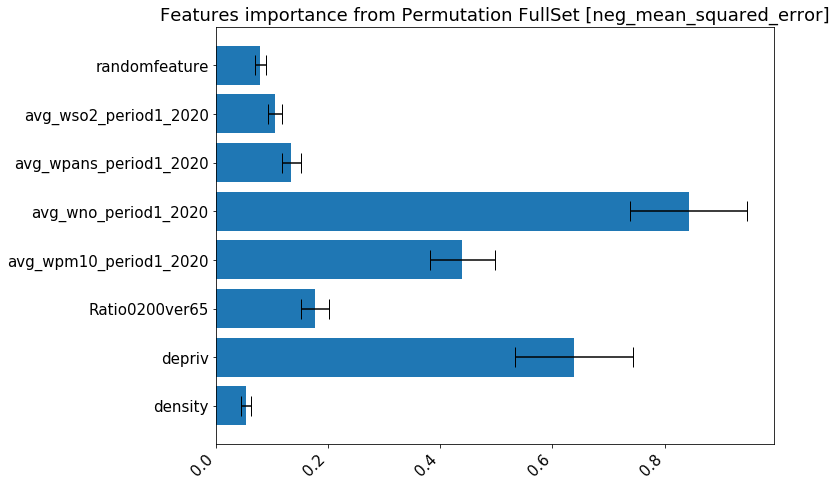

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02506 +/- 0.00405
Feature:                         depriv, Score: 0.29204 +/- 0.04821
Feature:                 Ratio0200ver65, Score: 0.08094 +/- 0.01179
Feature:         avg_wpm10_period1_2020, Score: 0.20120 +/- 0.02660
Feature:           avg_wno_period1_2020, Score: 0.38575 +/- 0.04757
Feature:         avg_wpans_period1_2020, Score: 0.06164 +/- 0.00791
Feature:          avg_wso2_period1_2020, Score: 0.04822 +/- 0.00583
Feature:                  randomfeature, Score: 0.03627 +/- 0.00456


<Figure size 432x288 with 0 Axes>

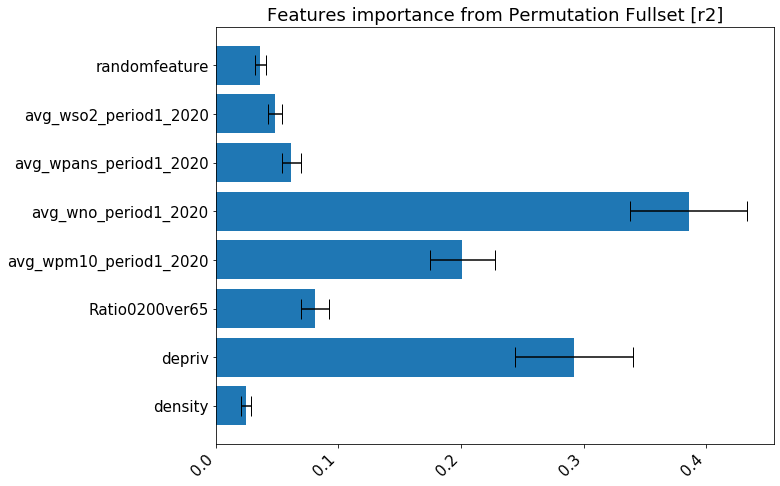

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.02042 +/- 0.01330
Feature:                         depriv, Score: 0.38446 +/- 0.14862
Feature:                 Ratio0200ver65, Score: 0.04430 +/- 0.05852
Feature:         avg_wpm10_period1_2020, Score: 0.03626 +/- 0.06232
Feature:           avg_wno_period1_2020, Score: 0.56013 +/- 0.17366
Feature:         avg_wpans_period1_2020, Score: 0.05395 +/- 0.04724
Feature:          avg_wso2_period1_2020, Score: -0.02870 +/- 0.03509
Feature:                  randomfeature, Score: 0.00985 +/- 0.01255


<Figure size 432x288 with 0 Axes>

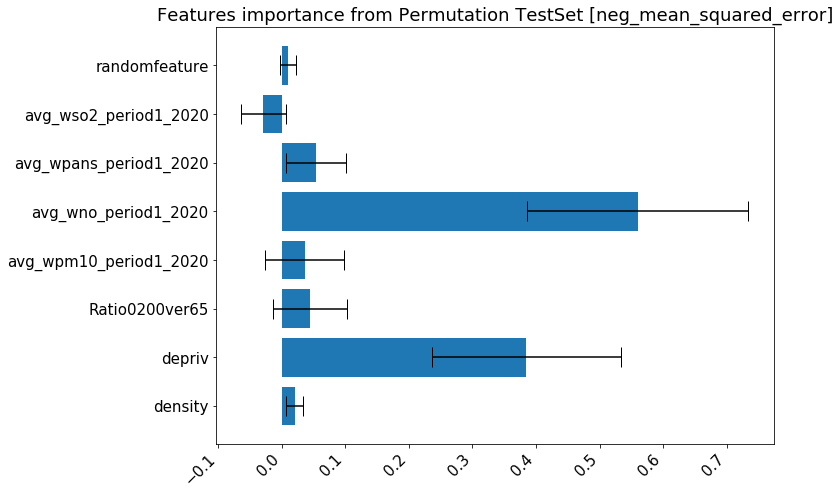

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.01396 +/- 0.00909
Feature:                         depriv, Score: 0.26275 +/- 0.10157
Feature:                 Ratio0200ver65, Score: 0.03028 +/- 0.04000
Feature:         avg_wpm10_period1_2020, Score: 0.02478 +/- 0.04259
Feature:           avg_wno_period1_2020, Score: 0.38281 +/- 0.11868
Feature:         avg_wpans_period1_2020, Score: 0.03687 +/- 0.03228
Feature:          avg_wso2_period1_2020, Score: -0.01962 +/- 0.02398
Feature:                  randomfeature, Score: 0.00673 +/- 0.00857


<Figure size 432x288 with 0 Axes>

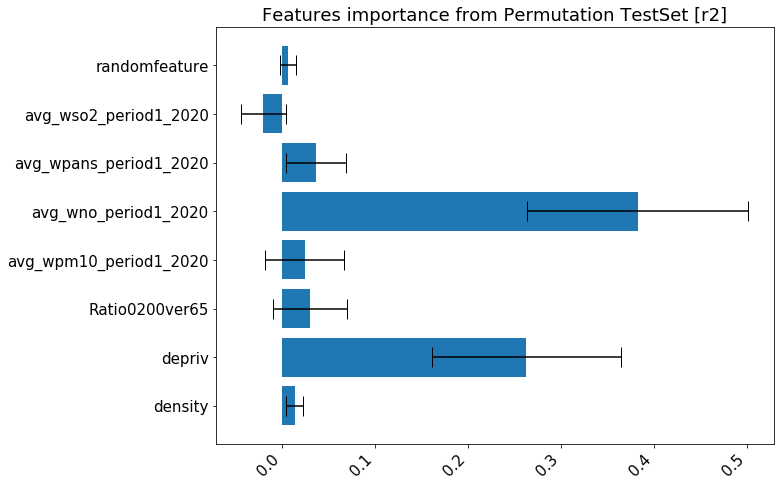

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05772 +/- 0.00685
Feature:                         depriv, Score: 0.67088 +/- 0.12518
Feature:                 Ratio0200ver65, Score: 0.22710 +/- 0.03038
Feature:         avg_wpm10_period1_2020, Score: 0.43048 +/- 0.06231
Feature:           avg_wno_period1_2020, Score: 1.18478 +/- 0.18271
Feature:         avg_wpans_period1_2020, Score: 0.12929 +/- 0.01918
Feature:          avg_wso2_period1_2020, Score: 0.15573 +/- 0.02162
Feature:                  randomfeature, Score: 0.05391 +/- 0.00695


<Figure size 432x288 with 0 Axes>

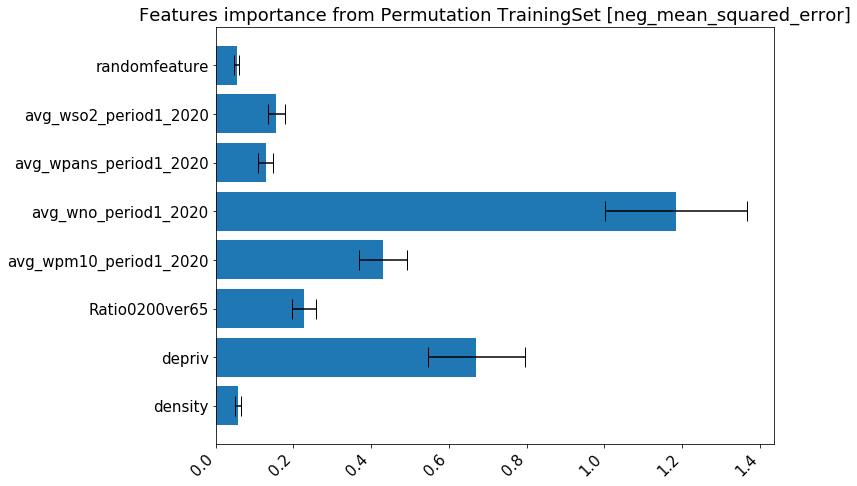

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02446 +/- 0.00290
Feature:                         depriv, Score: 0.28426 +/- 0.05304
Feature:                 Ratio0200ver65, Score: 0.09623 +/- 0.01287
Feature:         avg_wpm10_period1_2020, Score: 0.18240 +/- 0.02640
Feature:           avg_wno_period1_2020, Score: 0.50201 +/- 0.07742
Feature:         avg_wpans_period1_2020, Score: 0.05478 +/- 0.00813
Feature:          avg_wso2_period1_2020, Score: 0.06599 +/- 0.00916
Feature:                  randomfeature, Score: 0.02284 +/- 0.00294


<Figure size 432x288 with 0 Axes>

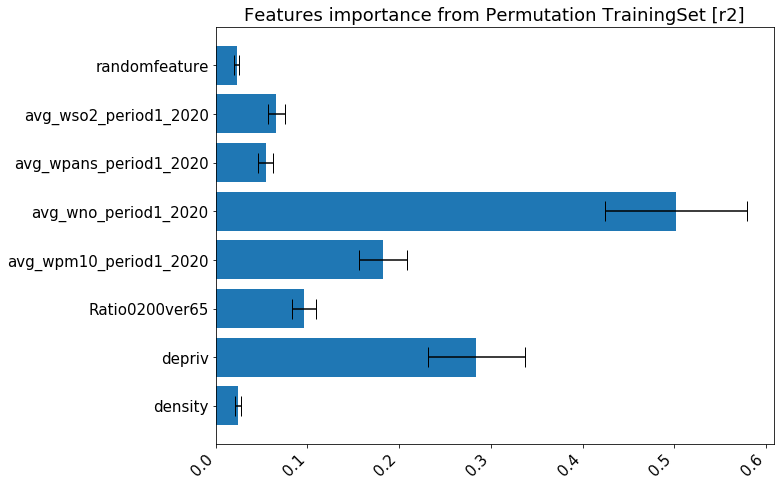

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_opttestset", showplot=True, optimisedparams=besthyperF)